# Preparation and Data Loading

## Environment Setup

In [1]:
# Use this only for the final pdf generation
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import median_abs_deviation

In [3]:
sc.settings.verbosity = 0             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.10.4 anndata==0.11.3 umap==0.5.7 numpy==1.26.4 scipy==1.15.1 pandas==2.2.3 scikit-learn==1.6.1 statsmodels==0.14.4 igraph==0.11.8 pynndescent==0.5.13


## Loading data

In [4]:
#adata_final = sc.read_h5ad("../../data/downstream/adatas/PBMC_indrops_final.h5ad")

In [5]:
# Loading cell-gene matrices:
adata_10x = sc.read_10x_mtx('../../data/downstream/matrices/PBMC_indrops_2/10x/')
adata_final = sc.read_10x_mtx('../../data/downstream/matrices/PBMC_indrops_2/final/')

In [6]:
print(adata_10x.X.sum())
print(adata_final.X.sum())
print(adata_final.X[:, adata_final.var_names.str.startswith("INTERGENIC")].sum())

101528410.0
103331250.0
2576684.0


In [7]:
adata_10x.var_names_make_unique()
adata_final.var_names_make_unique()
print(adata_10x)
print(adata_final)

AnnData object with n_obs × n_vars = 147456 × 38593
    var: 'gene_ids', 'feature_types'
AnnData object with n_obs × n_vars = 4822004 × 40849
    var: 'gene_ids', 'feature_types'


In [8]:
adata_10x.raw = adata_10x.copy()
adata_final.raw = adata_final.copy()

# Quality control

Firstly let's compute various metrics, which we will later use

In [9]:
# Geting various metrics, including amount mitochondrial, ribosomal and hemoglobin genes:
adata_10x.var['mt'] = adata_10x.var_names.str.startswith('MT')
adata_10x.var["ribo"] = adata_10x.var_names.str.startswith(("RPS", "RPL"))
adata_10x.var["hb"] = adata_10x.var_names.str.contains(("^HB[^(P)]"))
sc.pp.calculate_qc_metrics(adata_10x, qc_vars=['mt', 'ribo', 'hb'], percent_top=None, log1p=True, inplace=True)

adata_final.var['mt'] = adata_final.var_names.str.startswith('MT')
adata_final.var["ribo"] = adata_final.var_names.str.startswith(("RPS", "RPL"))
adata_final.var["hb"] = adata_final.var_names.str.contains(("^HB[^(P)]"))
sc.pp.calculate_qc_metrics(adata_final, qc_vars=['mt', 'ribo', 'hb'], percent_top=None, log1p=True, inplace=True)

## Filtering

Barcodes with very low counts may represent empty droplets, we need to filter them out.  
Let's visualize counts per cell and set tresholds to filter low quality cells:

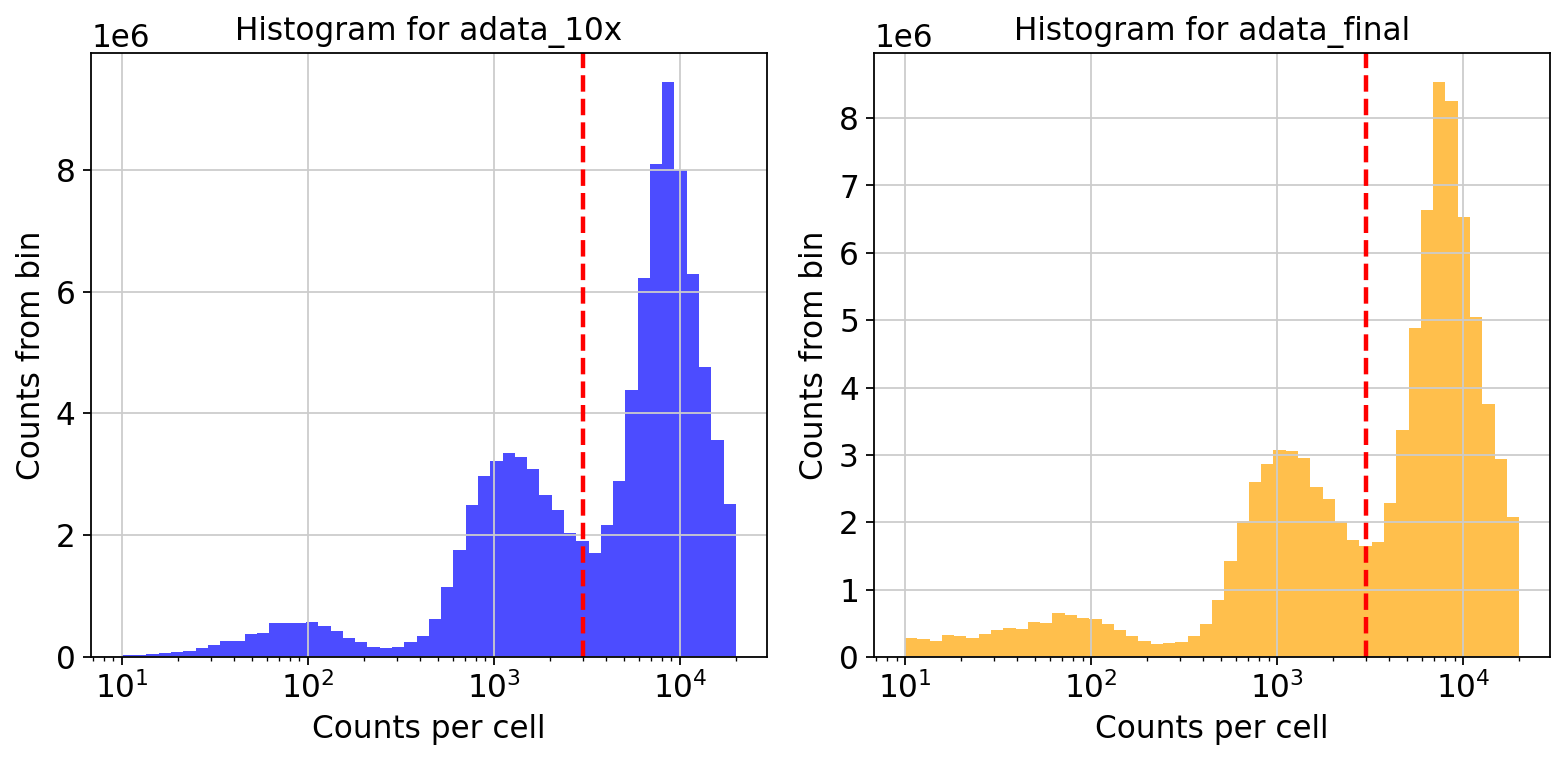

In [10]:
# Define bins
bins = np.logspace(np.log10(10), np.log10(20000), 51)

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# First subplot: adata_10x
axs[0].hist(
    adata_10x.obs["total_counts"], bins=bins, weights=adata_10x.obs["total_counts"],
    color="blue", alpha=0.7
)
axs[0].set_xscale('log')
axs[0].set_ylabel("Counts from bin")
axs[0].set_xlabel("Counts per cell")
axs[0].set_title("Histogram for adata_10x")
axs[0].axvline(x=3000, color='red', linestyle='dashed', linewidth=2)

# Second subplot: adata_final
axs[1].hist(
    adata_final.obs["total_counts"], bins=bins, weights=adata_final.obs["total_counts"],
    color="orange", alpha=0.7
)
axs[1].set_xscale('log')
axs[1].set_ylabel("Counts from bin")
axs[1].set_xlabel("Counts per cell")
axs[1].set_title("Histogram for adata_final")
axs[1].axvline(x=3000, color='red', linestyle='dashed', linewidth=2)

# Adjust layout and display
plt.tight_layout()
plt.show()

So let's filter cells based on the above treshholds:

In [11]:
cmask = adata_10x.obs['total_counts'].values>3000
adata_10x = adata_10x[cmask]

cmask = adata_final.obs['total_counts'].values>3000
adata_final = adata_final[cmask]

Filtering low expression genes:

In [12]:
# Filtering low expression genes:
sc.pp.filter_genes(adata_10x, min_cells=3)
sc.pp.filter_genes(adata_final, min_cells=3)

In [13]:
print(adata_10x.shape)
print(adata_final.shape)

(8074, 27353)
(7775, 29921)


Let's filter low quality cells. We will use automatic thresholding via MAD (median absolute deviations). The MAD is given by $ MAD = median(|X_i - median(X)|) $, with $X_i$ being the respective QC metric of an observation and describes a robust statistic of the variability of the metric. I will mark cells as outliers if they differ by 5 MADs which is a relatively permissive filtering strategy.

In [14]:
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

We will use thresholds on "log1p_total_counts", "log1p_n_genes_by_counts" and "pct_counts_mt", as abnormalities in these metrics might correspond to dying cells (e.g. if a membrane of a cell is damaged, cytoplasmic RNA migth leak out, while mitochondrial RNA remains for longer time, resulting in high percentage of mitochondrial genes and low total counts). We apply stricter thresholds for mitochondrial genes.

In [15]:
adata_10x.obs["outlier"] = (
    is_outlier(adata_10x, "log1p_total_counts", 5)
    | is_outlier(adata_10x, "log1p_n_genes_by_counts", 5)
    | is_outlier(adata_10x, "pct_counts_mt", 3)
    | (adata_10x.obs["pct_counts_mt"] > 10)
)

adata_final.obs["outlier"] = (
    is_outlier(adata_final, "log1p_total_counts", 5)
    | is_outlier(adata_final, "log1p_n_genes_by_counts", 5)
    | is_outlier(adata_final, "pct_counts_mt", 3)
    | (adata_final.obs["pct_counts_mt"] > 10)
)

In [16]:
print(f"Total number of cells: {adata_10x.n_obs}")
adata_10x = adata_10x[(~adata_10x.obs.outlier)].copy()
print(f"Number of cells after filtering of low quality cells: {adata_10x.n_obs}")

Total number of cells: 8074
Number of cells after filtering of low quality cells: 7615


In [17]:
print(f"Total number of cells: {adata_final.n_obs}")
adata_final = adata_final[(~adata_final.obs.outlier)].copy()
print(f"Number of cells after filtering of low quality cells: {adata_final.n_obs}")

Total number of cells: 7775
Number of cells after filtering of low quality cells: 7301


## Doublets Detections

In some rare cases, we can have two cells in one droplet, leading to so called "doublets". To overcome this problem, we need to filter out those barcodes. We will use the method called Scrublet.

In [18]:
sc.external.pp.scrublet(adata_10x)
sc.external.pp.scrublet(adata_final)

In [19]:
cmask = adata_10x.obs['predicted_doublet'].values == False
adata_10x = adata_10x[cmask]

cmask = adata_final.obs['predicted_doublet'].values == False
adata_final = adata_final[cmask]

In [20]:
print(adata_10x.shape)
print(adata_final.shape)

(7615, 27353)
(7301, 29921)


In [21]:
adata_10x.layers["celltypist"] = adata_10x.X
adata_final.layers["celltypist"] = adata_final.X

In [22]:
print(len([gene for gene in adata_final.var_names if gene.startswith("INTERGENIC")]))

2007


## Visualisation

Plotting highest expression genes:

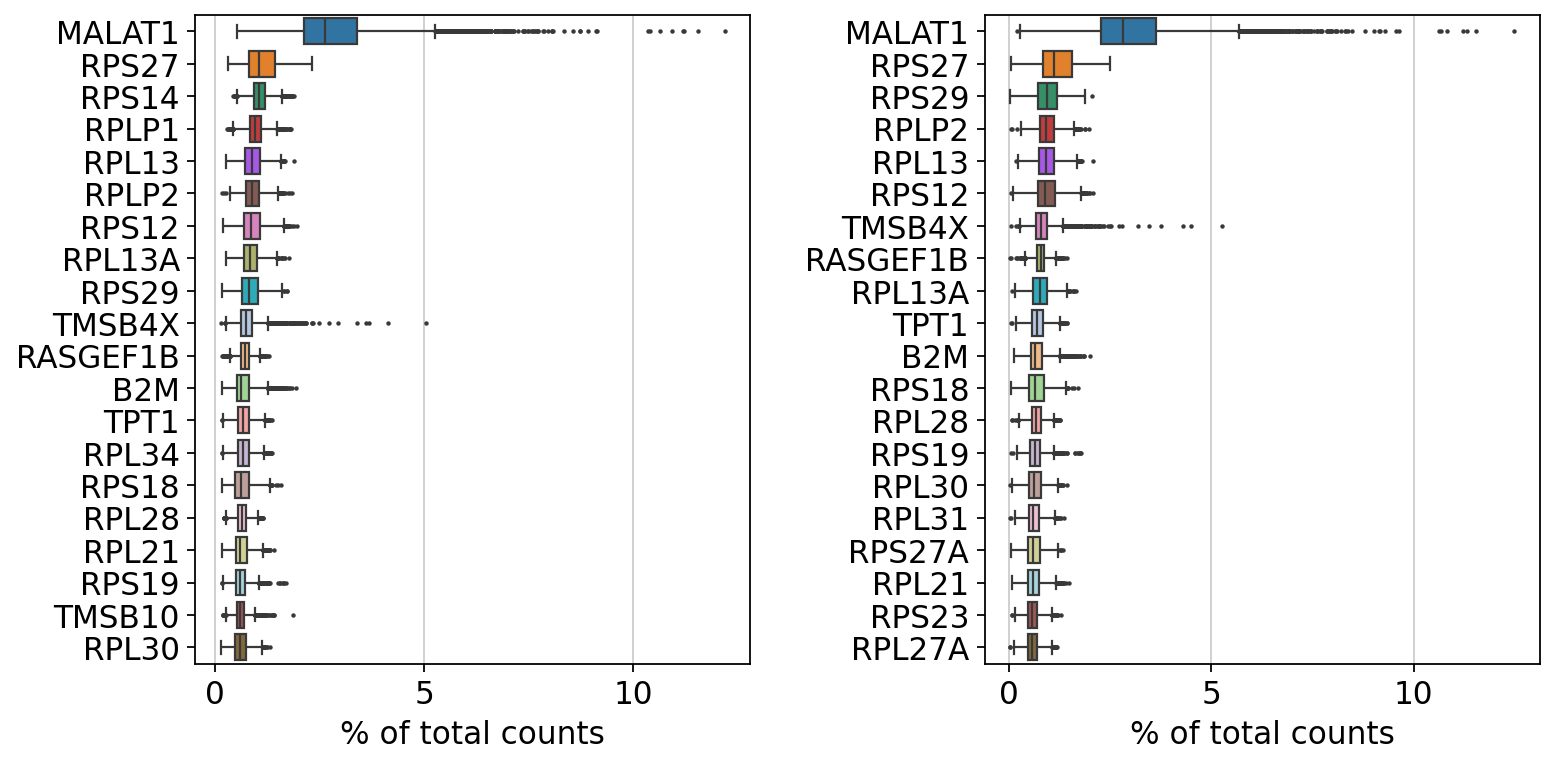

In [23]:
%matplotlib inline

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

sc.pl.highest_expr_genes(adata_10x, n_top=20, ax = axs[0], show = False)

sc.pl.highest_expr_genes(adata_final, n_top=20, ax = axs[1], show = False)

plt.tight_layout()
plt.show()

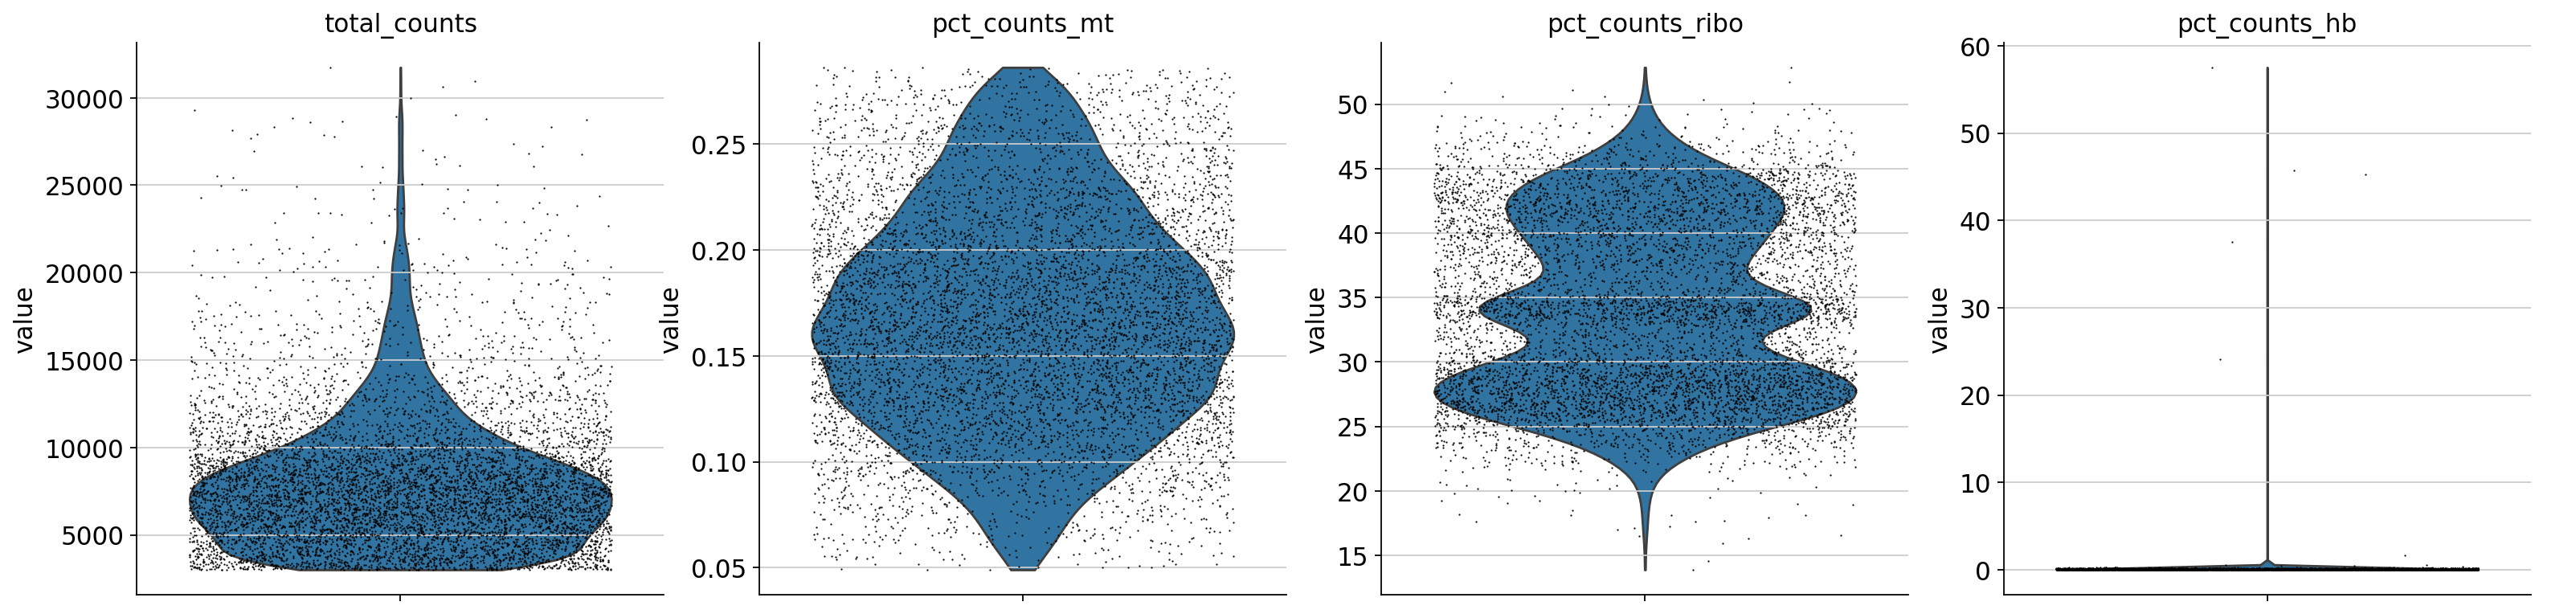

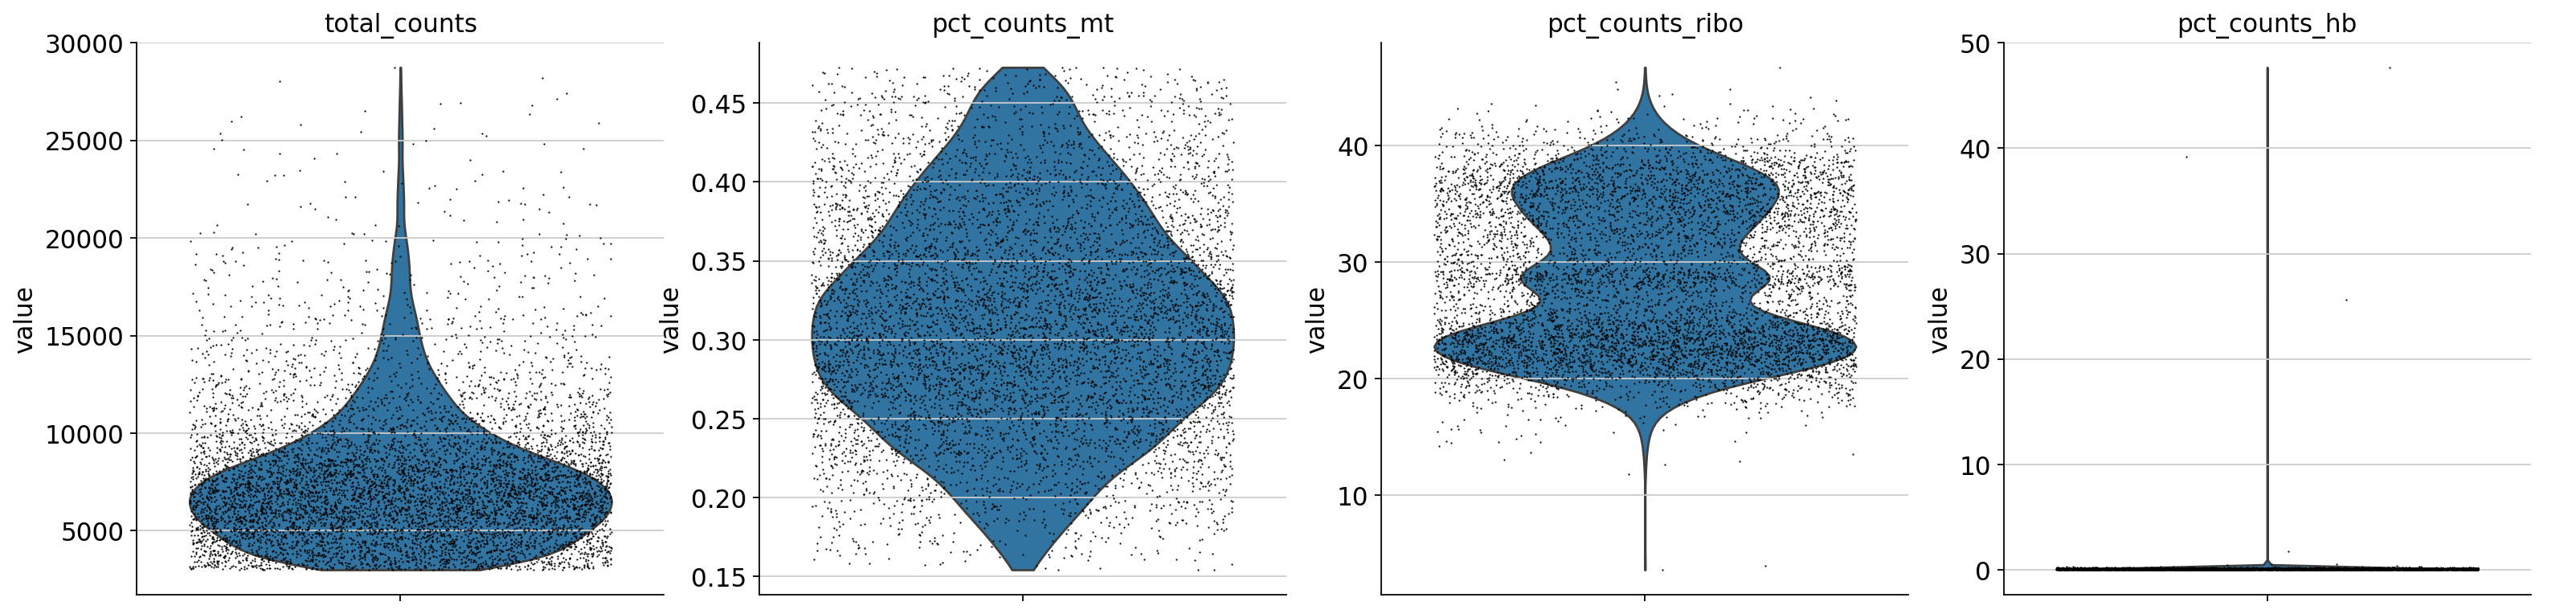

In [24]:
sc.pl.violin(adata_10x, keys=['total_counts', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb'], jitter=0.4, multi_panel=True)
sc.pl.violin(adata_final, keys=['total_counts', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb'], jitter=0.4, multi_panel=True)

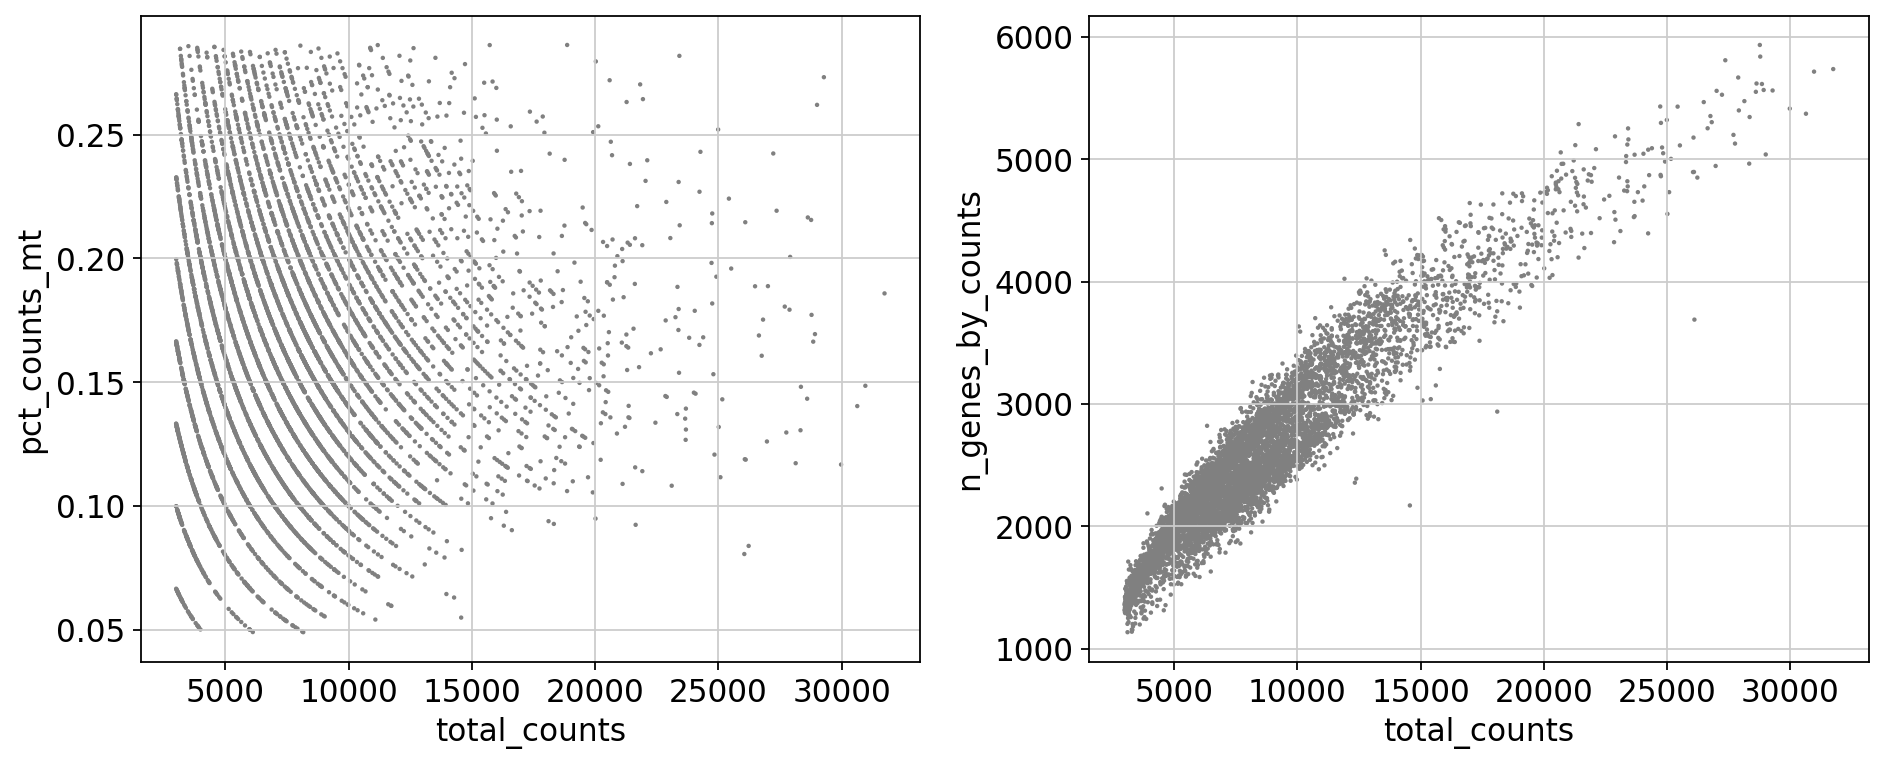

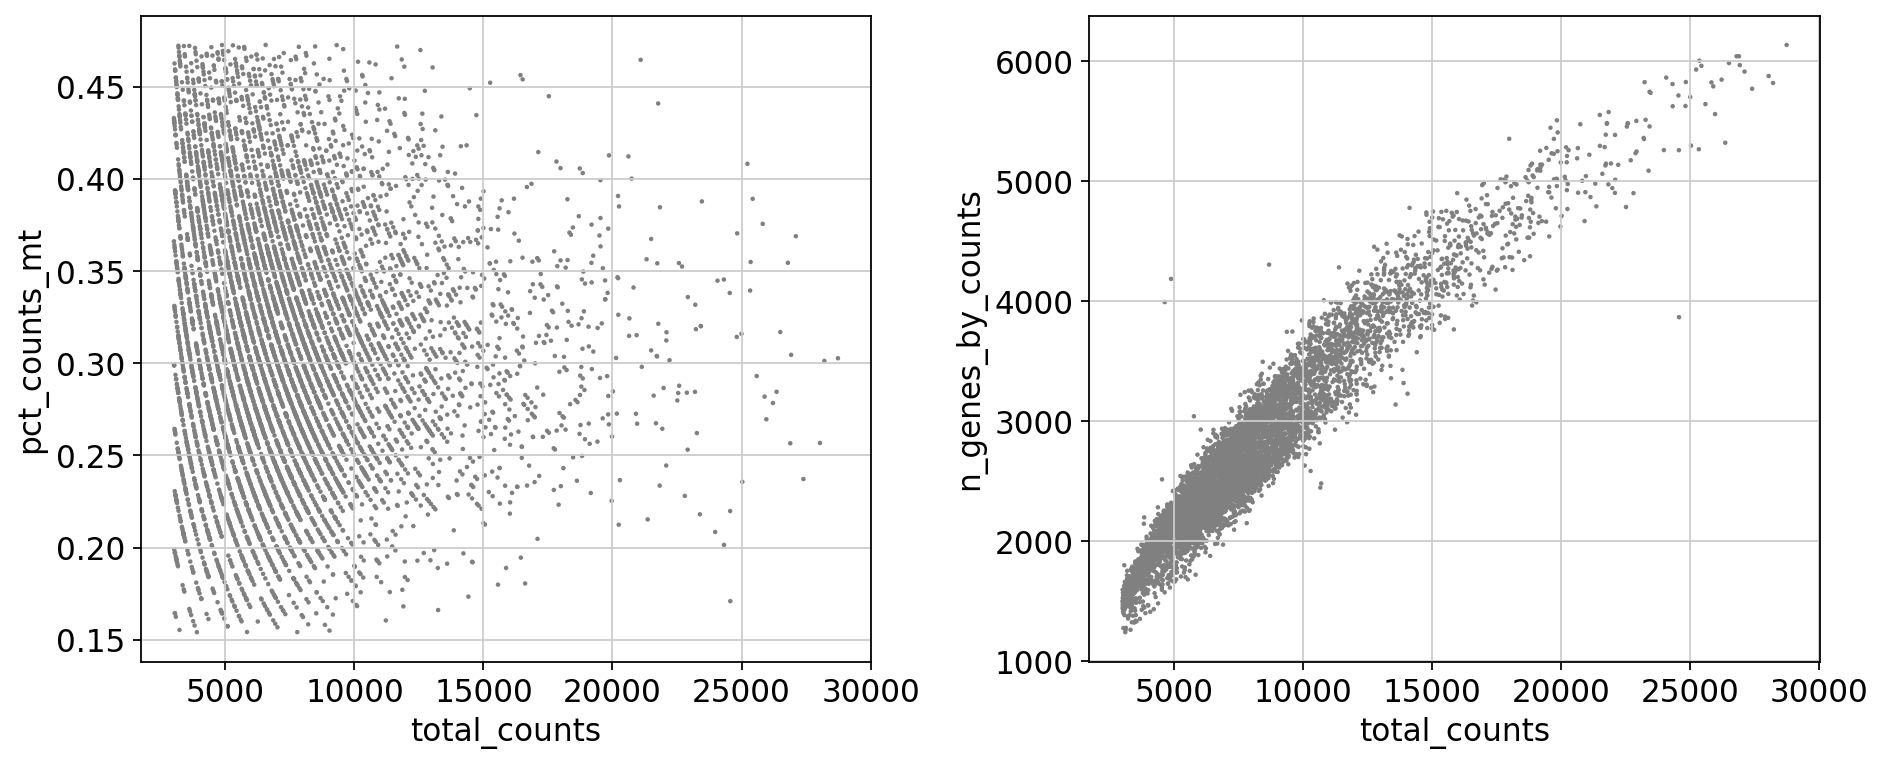

In [25]:
figure, axs = plt.subplots(1,2, figsize=(12,5))

sc.pl.scatter(adata_10x, x='total_counts', y='pct_counts_mt', ax=axs[0], show=False)
sc.pl.scatter(adata_10x, x='total_counts', y='n_genes_by_counts', ax=axs[1], show=False)

plt.tight_layout()
plt.show()

figure, axs = plt.subplots(1,2, figsize=(12,5))

sc.pl.scatter(adata_final, x='total_counts', y='pct_counts_mt', ax=axs[0], show=False)
sc.pl.scatter(adata_final, x='total_counts', y='n_genes_by_counts', ax=axs[1], show=False)

plt.tight_layout()
plt.show()

# Normalization

Differences in count data between cells migth be the result due to sampling effects. Hence before proceeding with analysis, we need to normilize data. There are several normalization techniques (e.g. the shifted logarithm transformation, scran normalization and analytic approximation of Pearson residuals), each are well suited for different tasks. Here we will use shifted logarithm transformation, which works well for stabilizing variance for subsequent dimensionality reduction and identification of differentially expressed genes.

Before normalization (adata_10x):


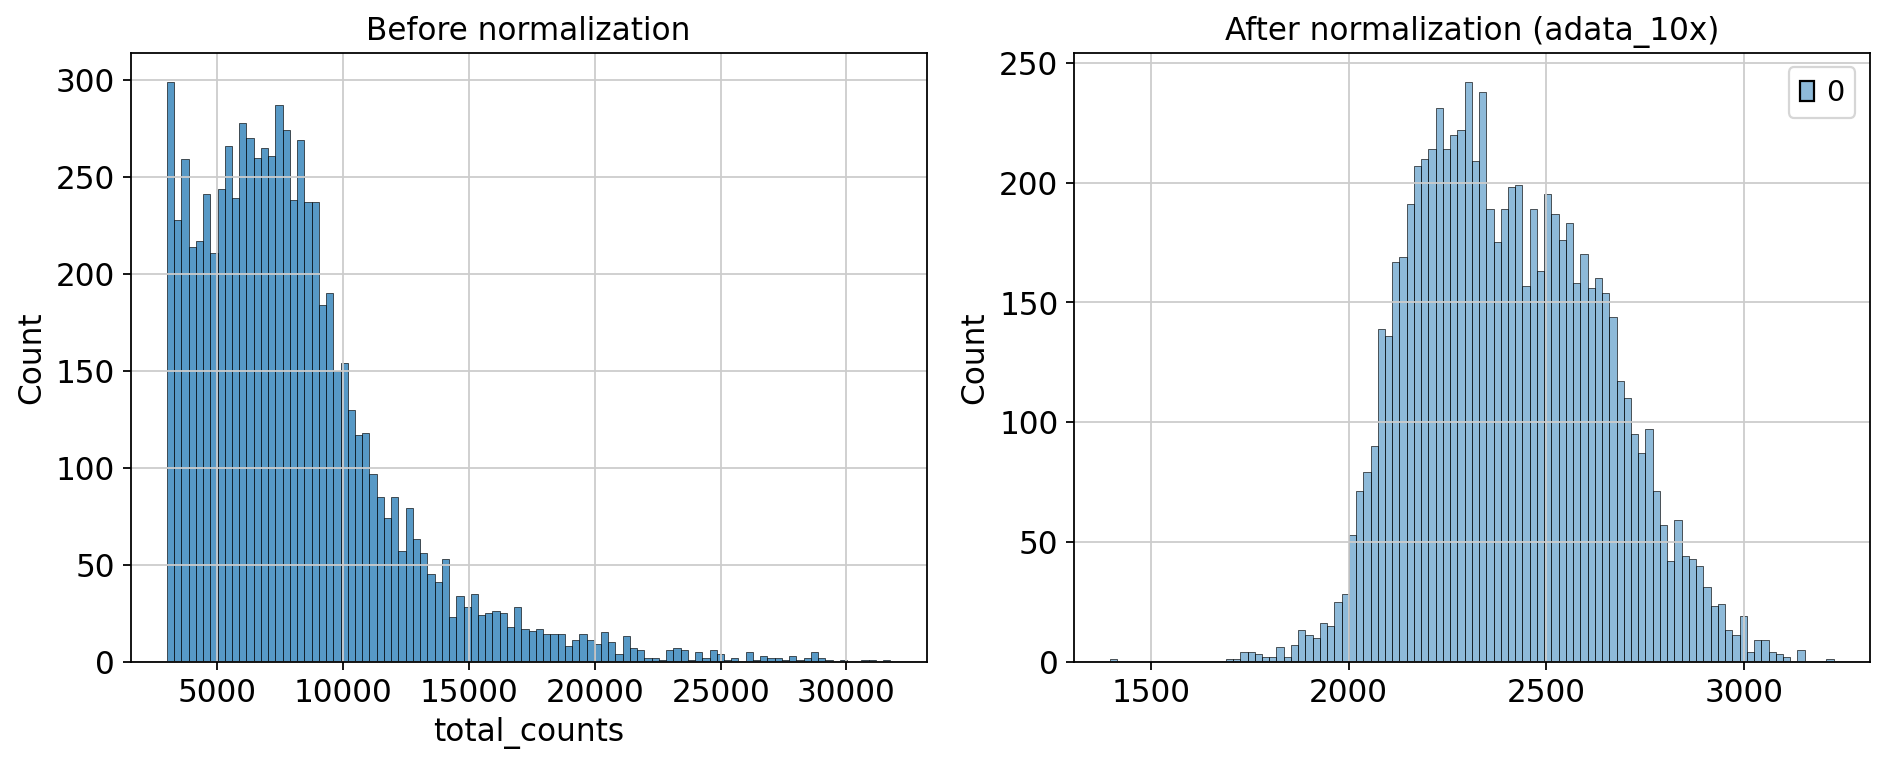

Before normalization (adata_final):


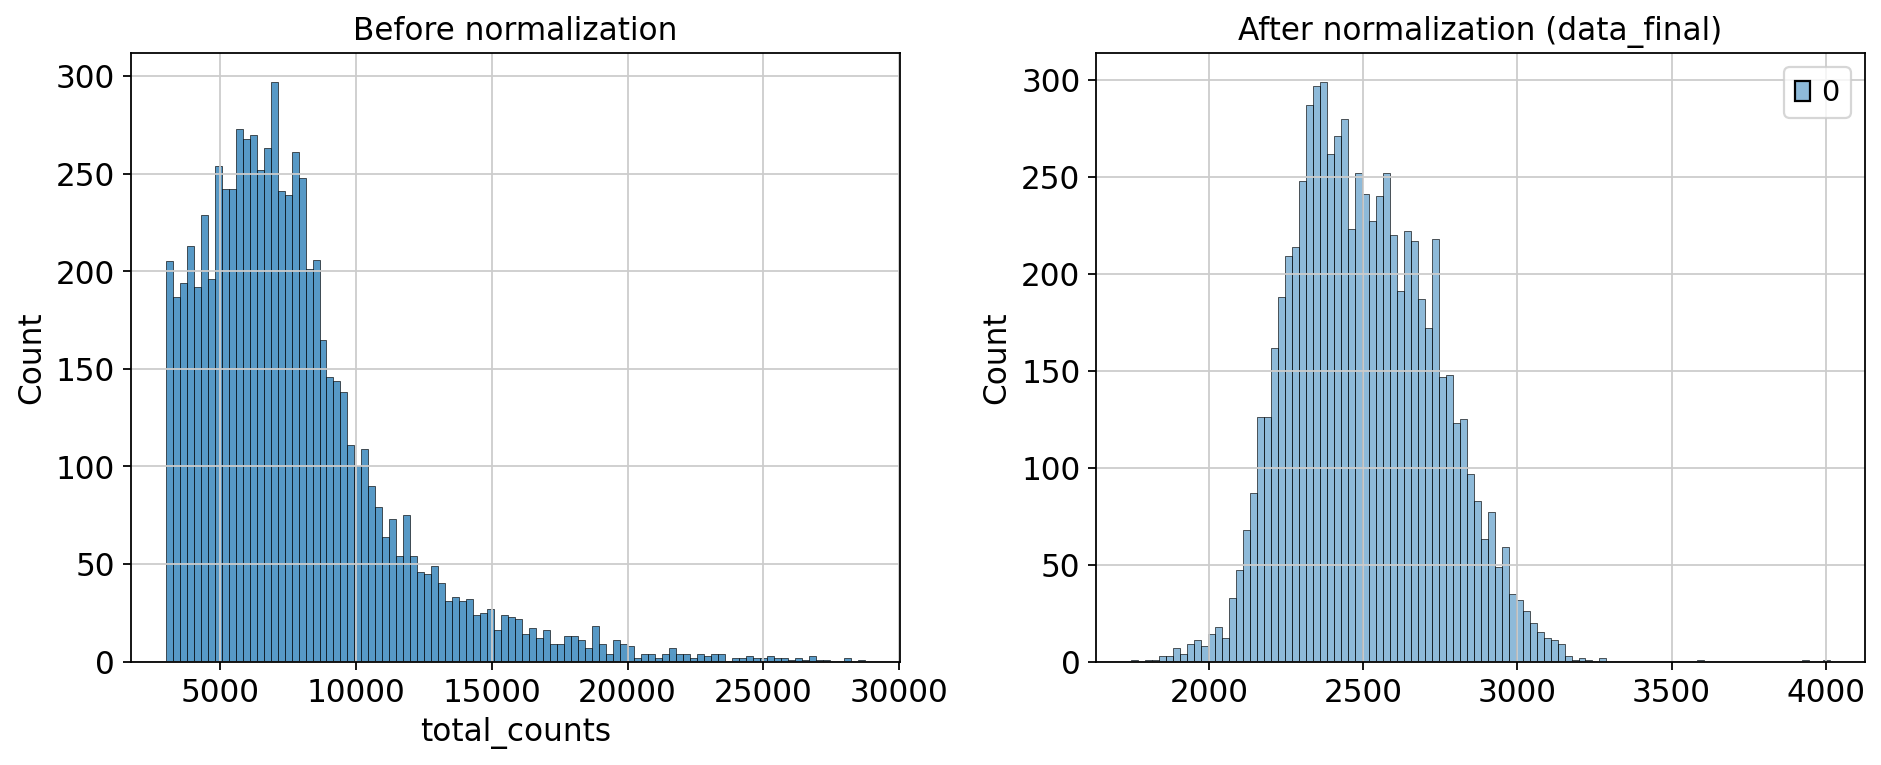

In [26]:
print("Before normalization (adata_10x):")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(adata_10x.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Before normalization")

sc.pp.normalize_total(adata_10x, target_sum=None)
sc.pp.log1p(adata_10x)

sns.histplot(adata_10x.X.sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("After normalization (adata_10x)")

plt.tight_layout()
plt.show()

print("Before normalization (adata_final):")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(adata_final.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Before normalization")

sc.pp.normalize_total(adata_final, target_sum=None)
sc.pp.log1p(adata_final)

sns.histplot(adata_final.X.sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("After normalization (data_final)")

plt.tight_layout()
plt.show()

# Feature Selection

In [27]:
sc.pp.highly_variable_genes(adata_10x, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.highly_variable_genes(adata_final, min_mean=0.0125, max_mean=3, min_disp=0.5)

In [28]:
adata_10x = adata_10x[:, adata_10x.var.highly_variable]
adata_final = adata_final[:, adata_final.var.highly_variable]

In [29]:
print(adata_10x.shape)
print(adata_final.shape)

(7615, 3454)
(7301, 3927)


In [30]:
print(len([gene for gene in adata_final.var_names if gene.startswith("INTERGENIC")]))

759


# Dimensionality reduction

## PCA

PCA is common strategy to construct the new set of variables with decreasing variance. In scRNA analysis, it is usually not used for clustering, instead, it is typically used to select the top 10-50 PCs which are used for downstream analysis tasks.

In [31]:
sc.tl.pca(adata_10x, svd_solver='arpack')
sc.tl.pca(adata_final, svd_solver='arpack')

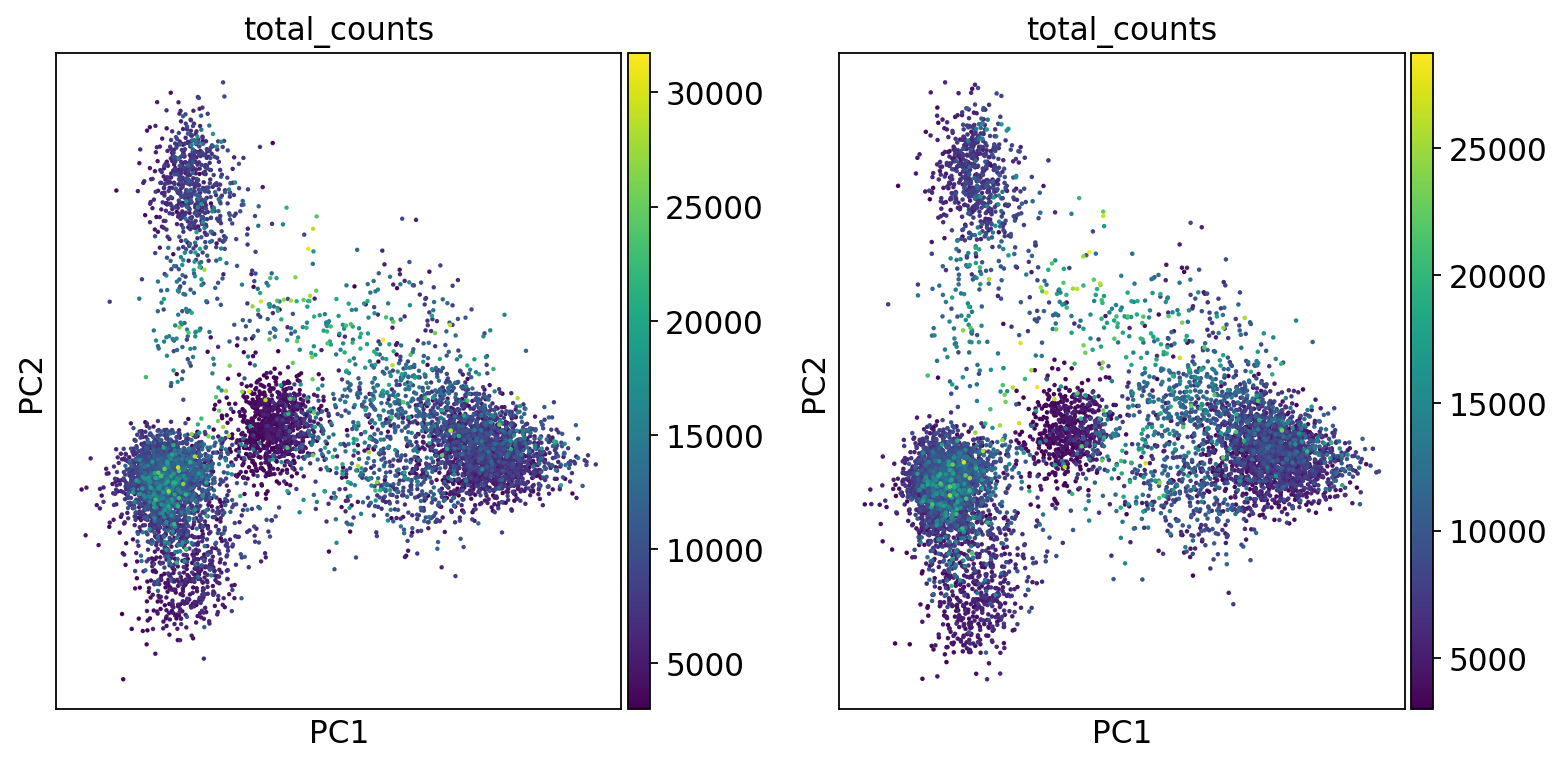

In [32]:
fig, axs = plt.subplots(1,2, figsize = (10,5))

sc.pl.pca(adata_10x, color='total_counts', show=False, ax = axs[0])
sc.pl.pca(adata_final, color='total_counts', show=False, ax = axs[1])

plt.tight_layout()
plt.show()

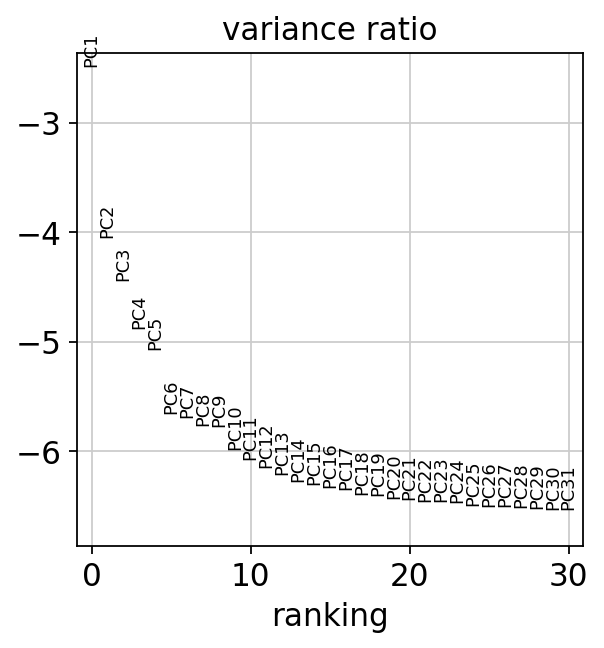

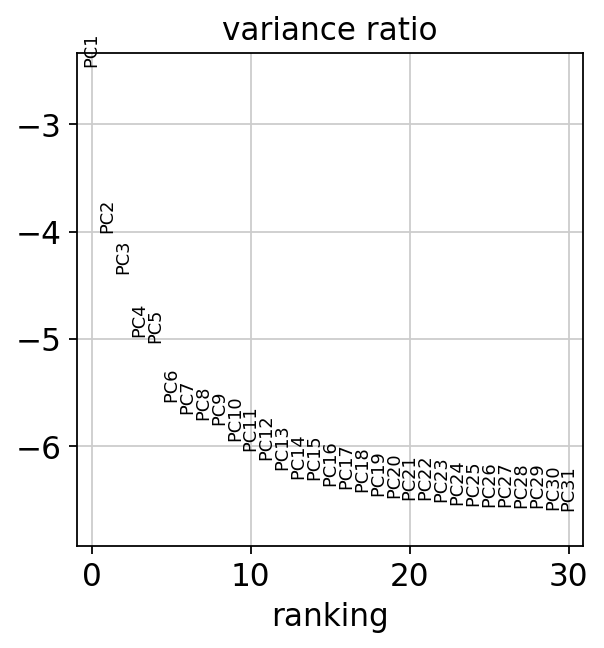

In [33]:
sc.pl.pca_variance_ratio(adata_10x, log=True)
sc.pl.pca_variance_ratio(adata_final, log=True)

## t-SNE

t-SNE is a graph based, non-linear dimensionality reduction technique which projects the high dimensional data onto 2D or 3D components.

In [34]:
sc.tl.tsne(adata_10x, n_pcs = 6)
sc.tl.tsne(adata_final, n_pcs = 6)

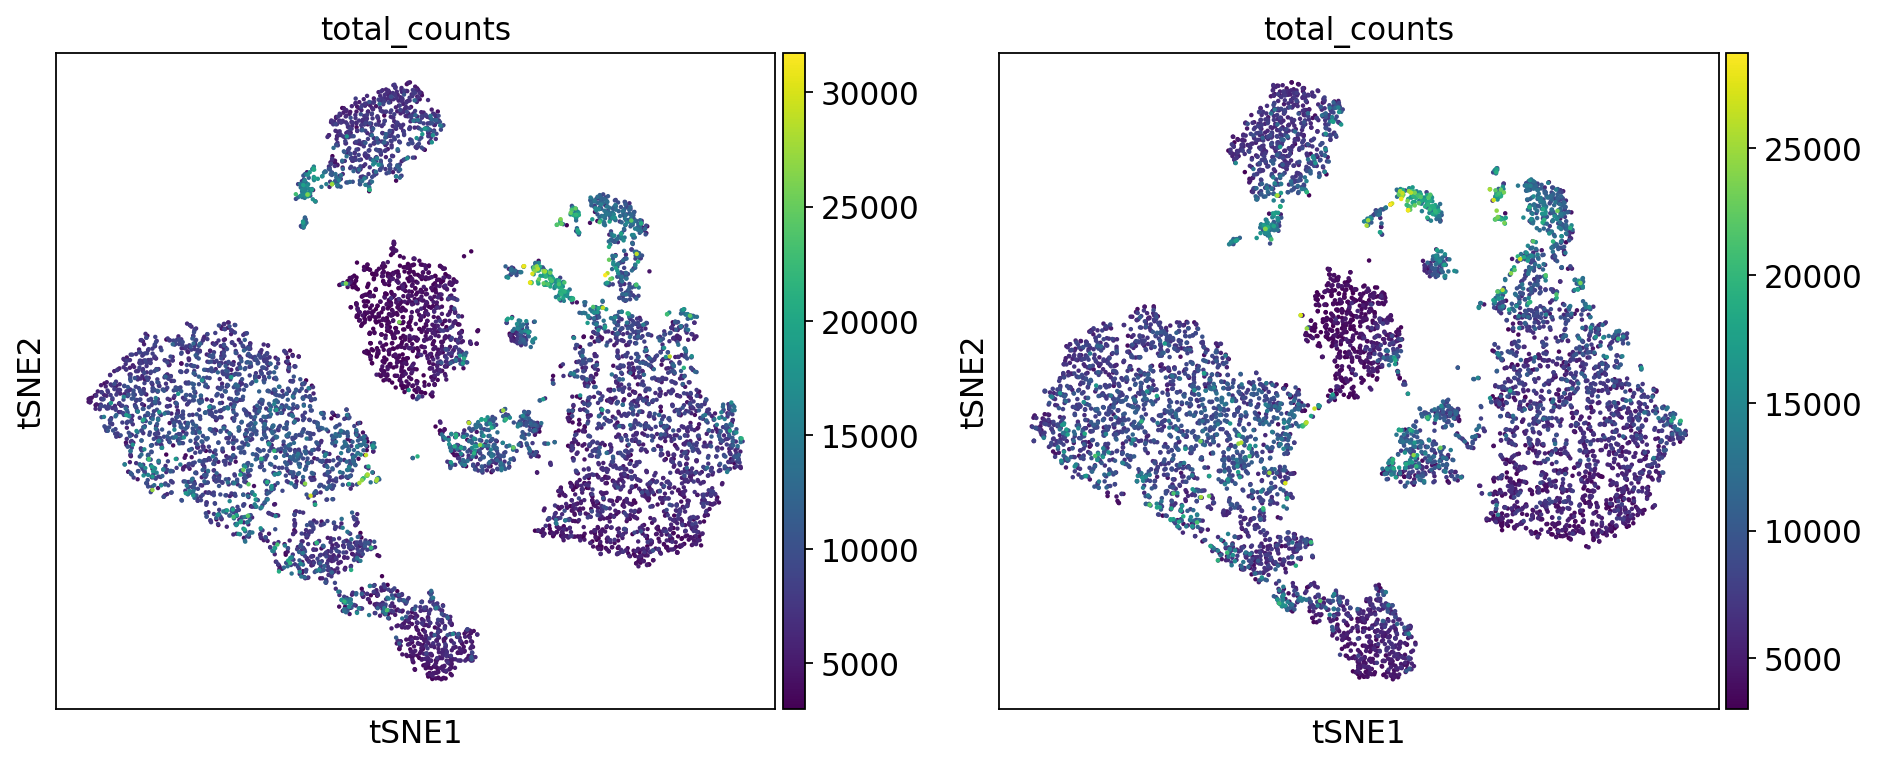

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))

sc.pl.tsne(adata_10x, color="total_counts", show=False, ax=axs[0])
sc.pl.tsne(adata_final, color="total_counts", show=False, ax=axs[1])

plt.tight_layout()
plt.show()

## UMAP

UMAP is a graph based, non-linear dimensionality reduction technique and principally similar to t-SNE. To use UMAP, we firstly need to compute PCA and neighbours:

In [36]:
sc.pp.neighbors(adata_10x, n_pcs = 6)
sc.tl.umap(adata_10x)

sc.pp.neighbors(adata_final, n_pcs = 6)
sc.tl.umap(adata_final)

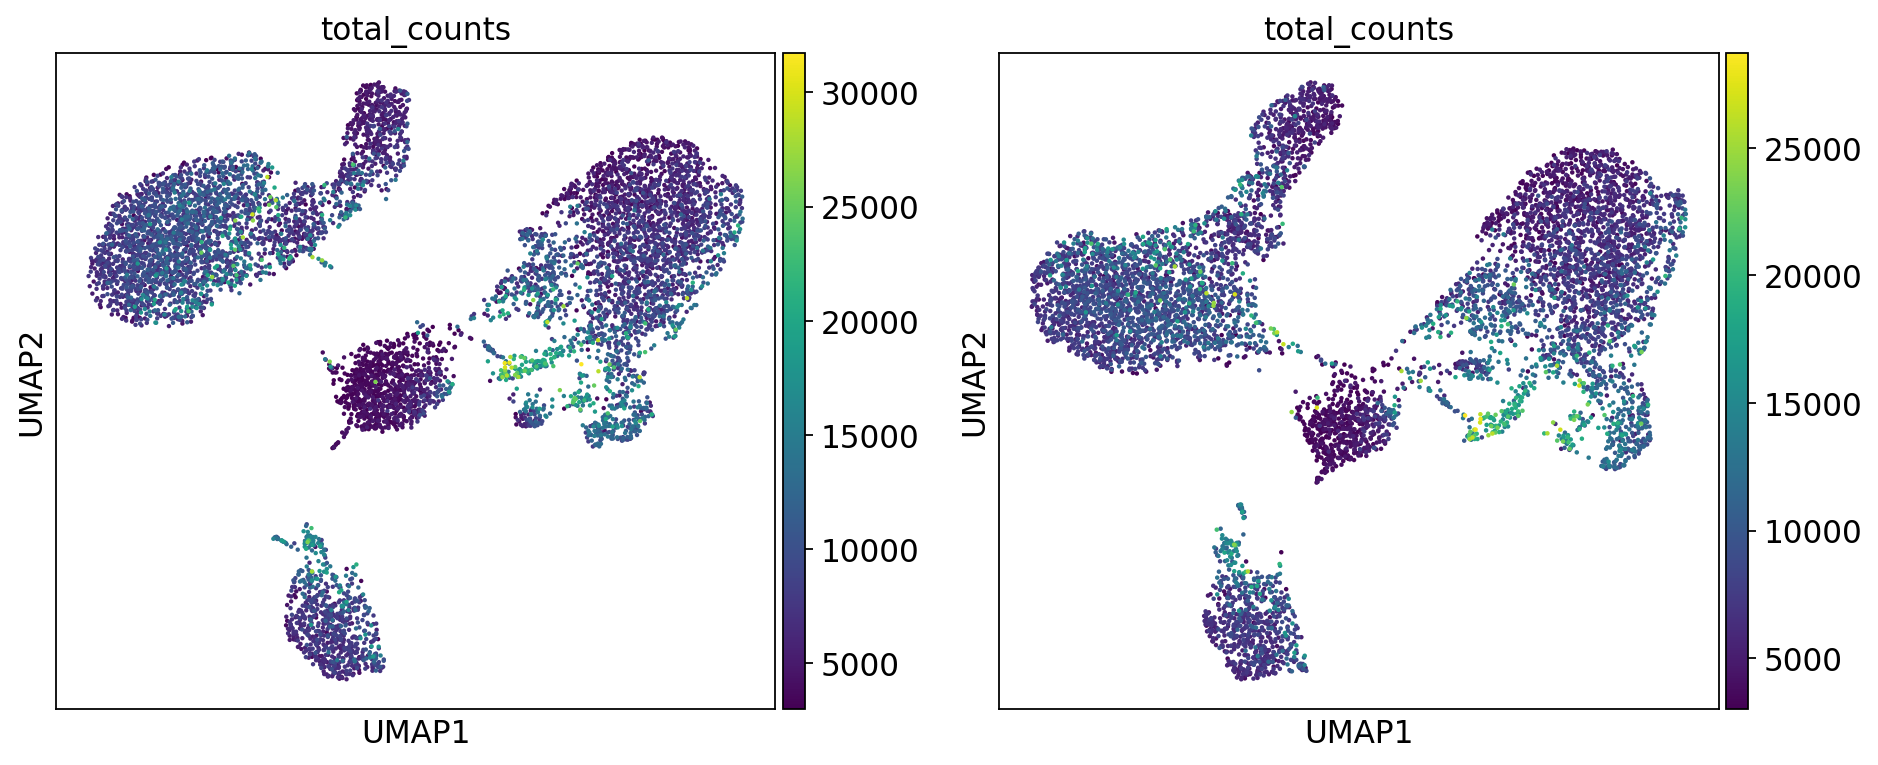

In [37]:
fig, axs = plt.subplots(1, 2, figsize = (12,5))

sc.pl.umap(adata_10x, color="total_counts", show=False, ax = axs[0])
sc.pl.umap(adata_final, color="total_counts", show=False, ax = axs[1])

plt.tight_layout()
plt.show()

# Clustering

Now let's use some cluster algorithms to separate different (sub)types of cells. We can roughly see different groups visually in the graphs of reduced dimension above. However, using various developed algorithms is more precise way to do that. Here we will use Leiden algorithm.

In [38]:
sc.tl.leiden(adata_10x, resolution=1, key_added="leiden1")
sc.tl.leiden(adata_10x, resolution=0.5, key_added="leiden05")
sc.tl.leiden(adata_10x, resolution=2, key_added="leiden2")

sc.tl.leiden(adata_final, resolution=1, key_added="leiden1")
sc.tl.leiden(adata_final, resolution=0.5, key_added="leiden05")
sc.tl.leiden(adata_final, resolution=2, key_added="leiden2")

10x


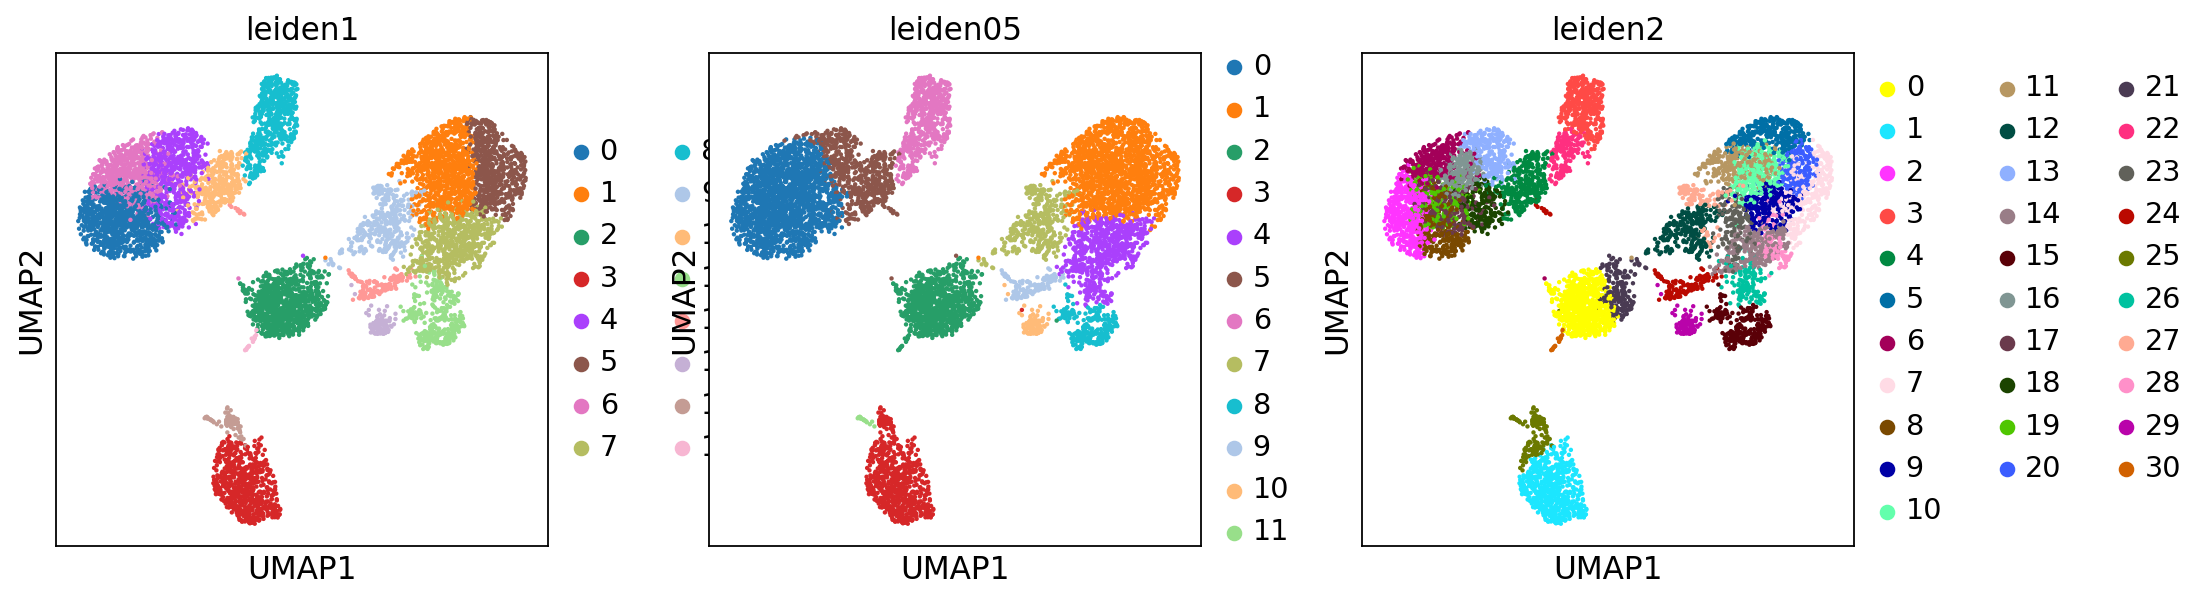

In [39]:
print("10x")
sc.pl.umap(adata_10x, color=['leiden1', 'leiden05', 'leiden2'])

final


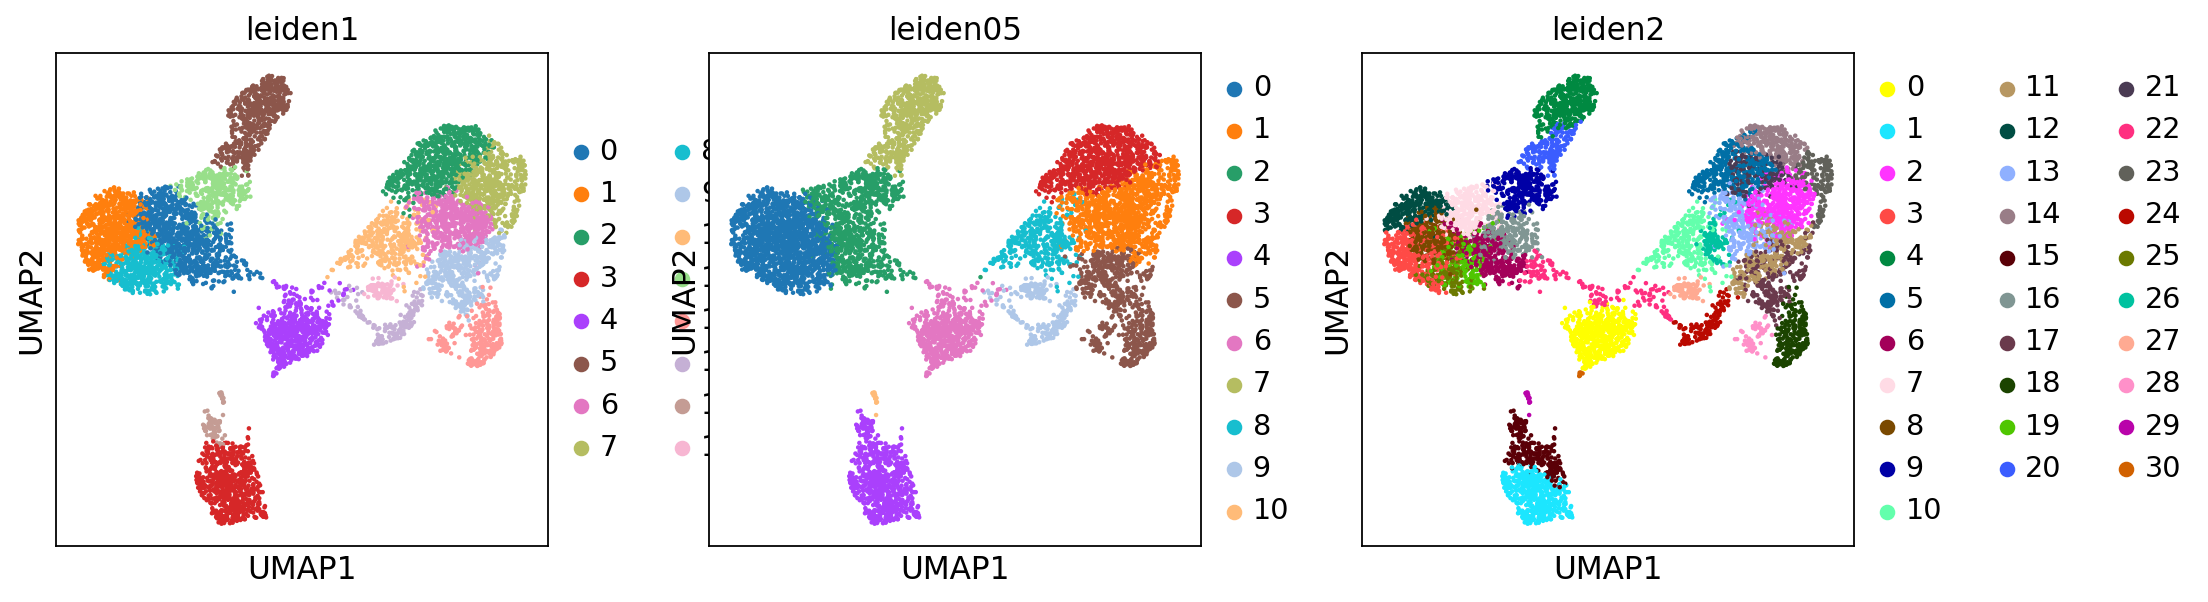

In [40]:
print("final")
sc.pl.umap(adata_final, color=['leiden1', 'leiden05', 'leiden2'])

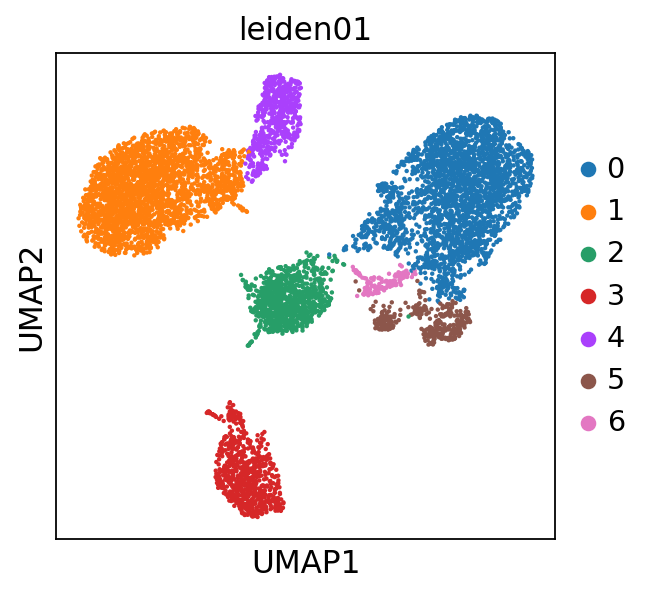

In [41]:
sc.tl.leiden(adata_10x, resolution=0.1, key_added="leiden01")
sc.pl.umap(adata_10x, color='leiden01')

# Annotation

## Automatic annotation

In [42]:
import celltypist
from celltypist import models

In [43]:
def CellTypist(adata):
    models.download_models(force_update=True, model=["Immune_All_Low.pkl", "Immune_All_High.pkl"])
    model_low = models.Model.load(model="Immune_All_Low.pkl")
    model_high = models.Model.load(model="Immune_All_High.pkl")
    
    adata_celltypist = adata.copy()
    adata_celltypist.X = adata.layers["celltypist"]
    sc.pp.normalize_total(adata_celltypist, target_sum = 10000)
    sc.pp.log1p(adata_celltypist)
    adata_celltypist.X = adata_celltypist.X.toarray()

    predictions_high = celltypist.annotate(adata_celltypist, model=model_high, majority_voting=True)
    predictions_high_adata = predictions_high.to_adata()
    adata.obs["celltypist_cell_label_coarse"] = predictions_high_adata.obs.loc[
        adata.obs.index, "majority_voting"]
    adata.obs["celltypist_conf_score_coarse"] = predictions_high_adata.obs.loc[
        adata.obs.index, "conf_score"]
    sc.pl.umap(adata,
        color=["celltypist_cell_label_coarse", "celltypist_conf_score_coarse"],
        frameon=False,
        sort_order=False,
        wspace=1,
        legend_loc = "on data")
    
    predictions_low = celltypist.annotate(adata_celltypist, model=model_low, majority_voting=True)
    predictions_low_adata = predictions_low.to_adata()
    adata.obs["celltypist_cell_label_fine"] = predictions_low_adata.obs.loc[
        adata.obs.index, "majority_voting"]
    adata.obs["celltypist_conf_score_fine"] = predictions_low_adata.obs.loc[
        adata.obs.index, "conf_score"]
    sc.pl.umap(adata,
        color=["celltypist_cell_label_fine", "celltypist_conf_score_fine"],
        frameon=False,
        sort_order=False,
        wspace=1)

📜 Retrieving model list from server https://celltypist.cog.sanger.ac.uk/models/models.json
📚 Total models in list: 54
📂 Storing models in /home/MazutisLab/.celltypist/data/models
💾 Total models to download: 2
💾 Downloading model [1/2]: Immune_All_Low.pkl
💾 Downloading model [2/2]: Immune_All_High.pkl
🔬 Input data has 7615 cells and 3454 genes
🔗 Matching reference genes in the model
🧬 1502 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


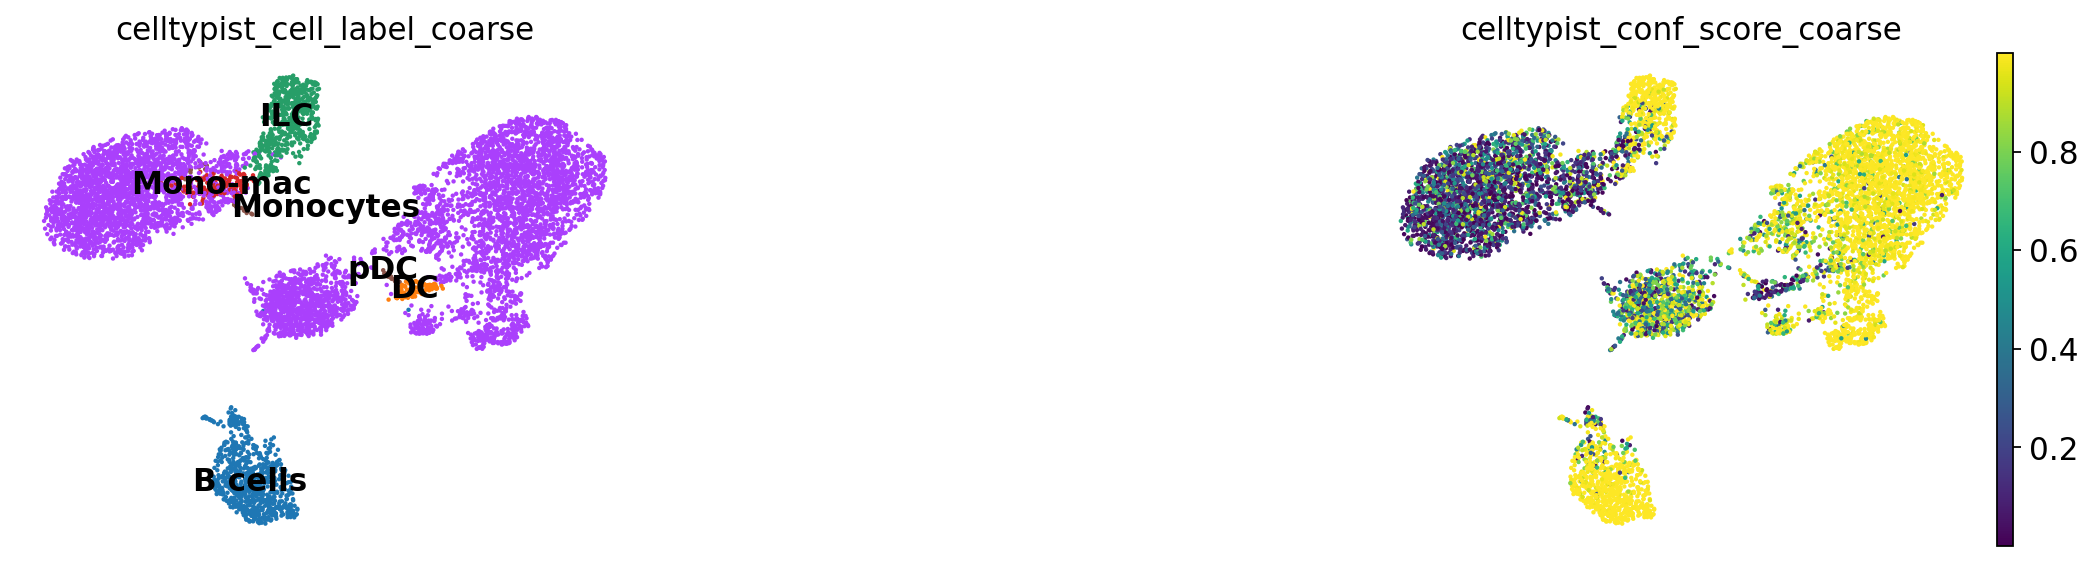

🔬 Input data has 7615 cells and 3454 genes
🔗 Matching reference genes in the model
🧬 1502 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


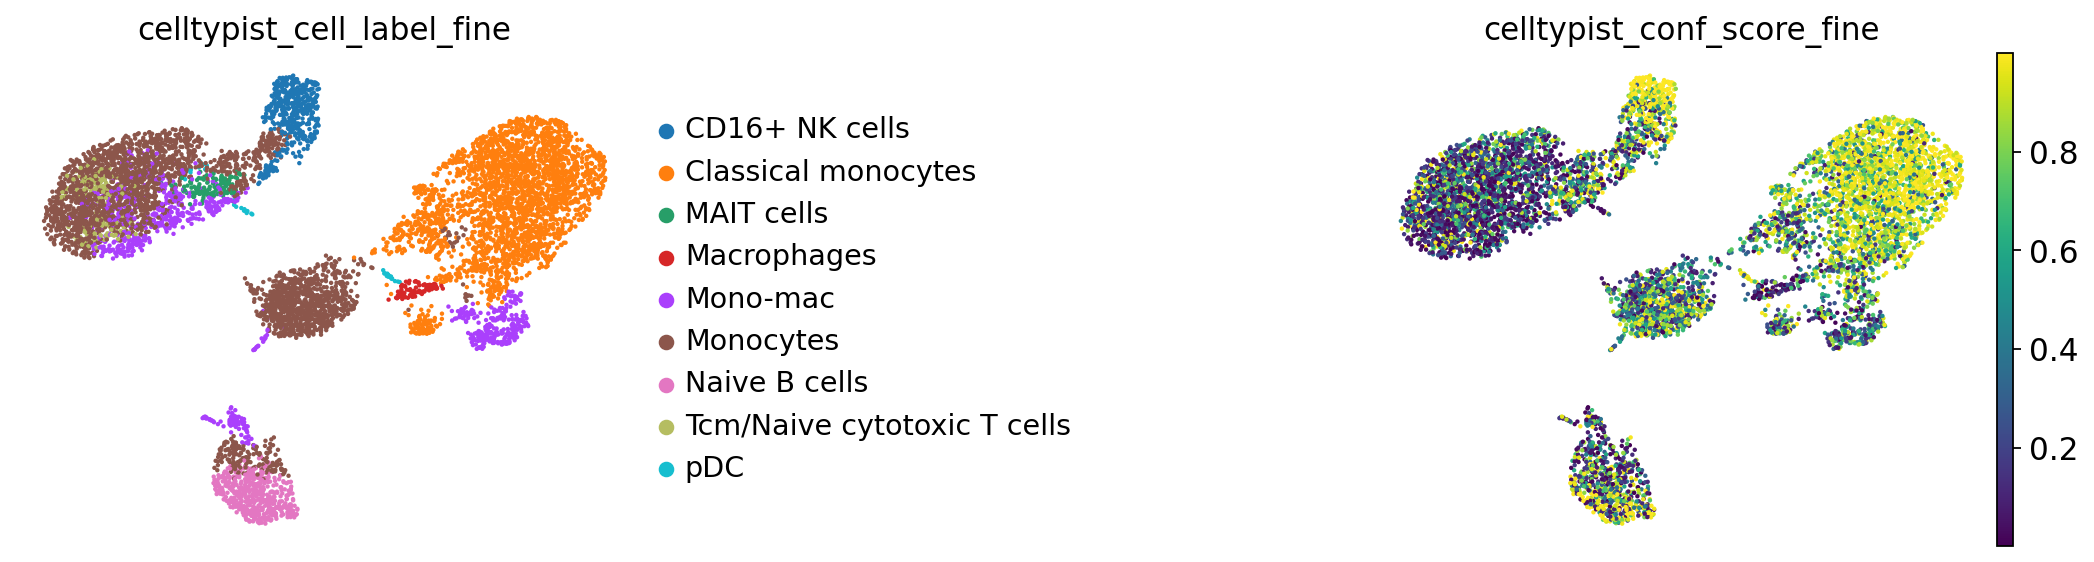

📜 Retrieving model list from server https://celltypist.cog.sanger.ac.uk/models/models.json
📚 Total models in list: 54
📂 Storing models in /home/MazutisLab/.celltypist/data/models
💾 Total models to download: 2
💾 Downloading model [1/2]: Immune_All_Low.pkl
💾 Downloading model [2/2]: Immune_All_High.pkl
🔬 Input data has 7301 cells and 3927 genes
🔗 Matching reference genes in the model
🧬 1409 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


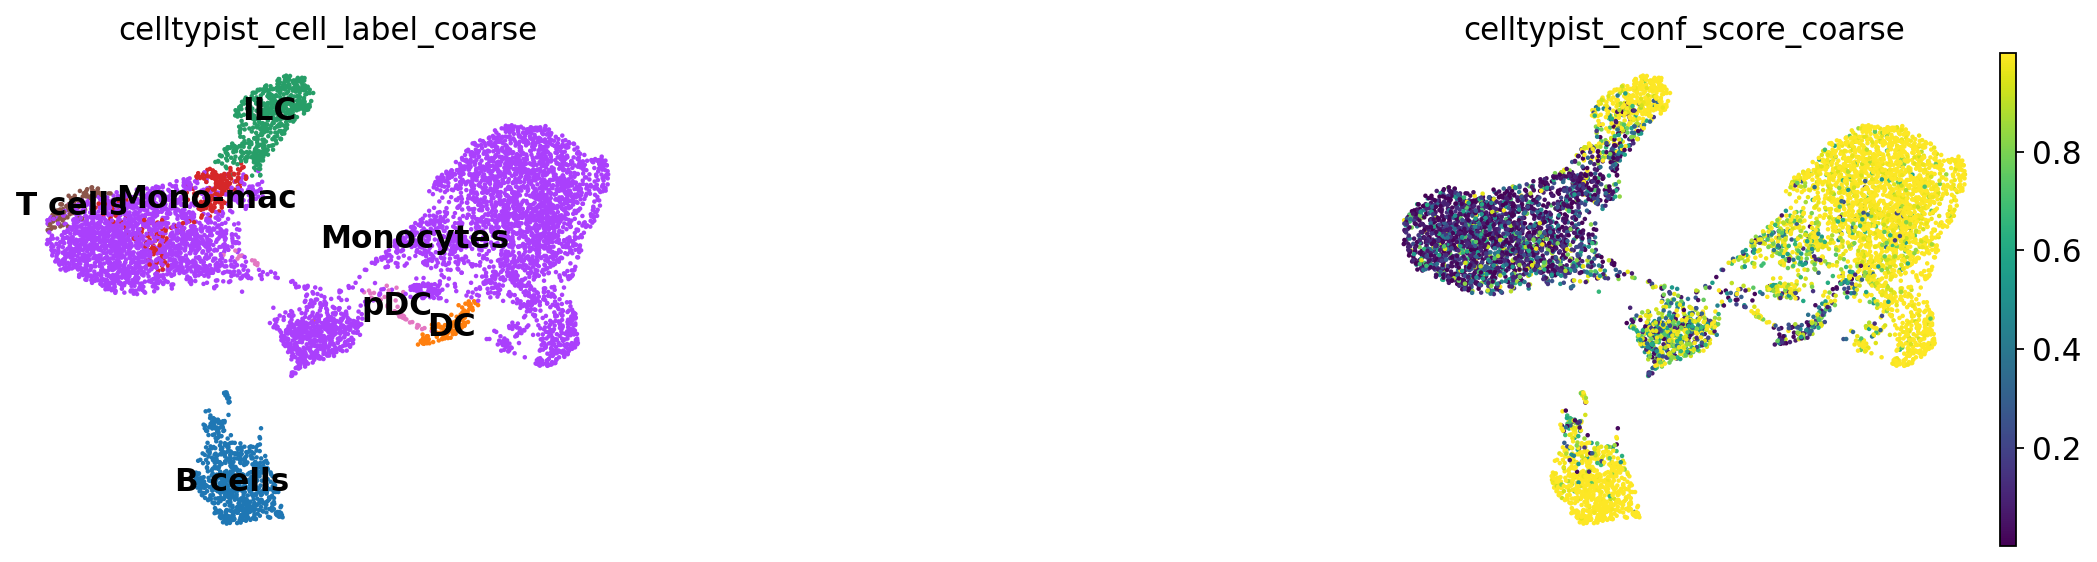

🔬 Input data has 7301 cells and 3927 genes
🔗 Matching reference genes in the model
🧬 1409 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


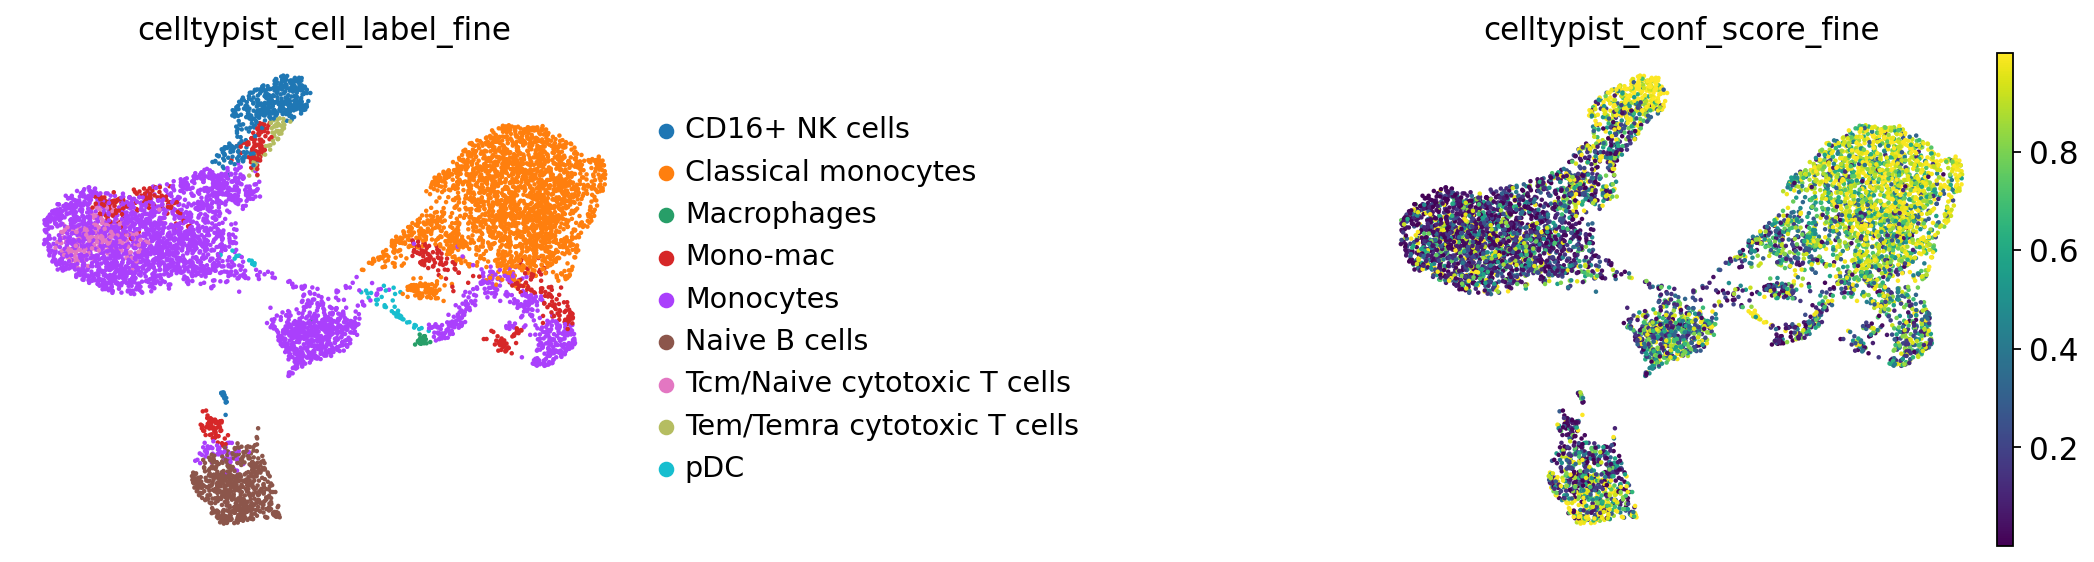

In [44]:
CellTypist(adata_10x)
CellTypist(adata_final)

# INTERGENIC

In [45]:
#sc.pl.tsne(adata_final, color=[gene for gene in adata_final.var_names if gene.startswith("INTERGENIC")], show=True)

sc.settings.figdir = "../../images/umap_images_intergenic_regions/PBMC_indrops_2/highly_variable/"

for gene in [gene for gene in adata_final.var_names if gene.startswith("INTERGENIC")]:
    sc.pl.umap(adata_final, color=gene, use_raw = False, save=f"{gene}.png", show=False)


In [46]:
sc.settings.figdir = "../../images/umap_images_intergenic_regions/PBMC_indrops_2/all/"

for gene in [gene for gene in adata_final.raw.var_names if gene.startswith("INTERGENIC")]:
    sc.pl.umap(adata_final, color=gene, use_raw = True, save=f"{gene}.png", show=False)

In [47]:
adata_final.write("../../data/downstream/adatas/PBMC_indrops_2_final.h5ad")
adata_10x.write("../../data/downstream/adatas/PBMC_indrops_2.h5ad")

... storing 'feature_types' as categorical
... storing 'feature_types' as categorical


## Loading data

In [49]:
# Loading cell-gene matrices:
adata = sc.read_10x_mtx('../../data/downstream/matrices/PBMC_indrops_2/final/')

In [50]:
adata = adata[:, adata.var_names.str.startswith("INTERGENIC")].copy()

In [51]:
print(adata.X.sum())

2576684.0


In [52]:
adata.var_names_make_unique()
print(adata)

AnnData object with n_obs × n_vars = 4822004 × 2008
    var: 'gene_ids', 'feature_types'


# Quality control

Firstly let's compute various metrics, which we will later use

In [53]:
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=True, inplace=True)

In [54]:
print(adata)

AnnData object with n_obs × n_vars = 4822004 × 2008
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'


## Filtering

Barcodes with very low counts may represent empty droplets, we need to filter them out.  
Let's visualize counts per cell and set tresholds to filter low quality cells:

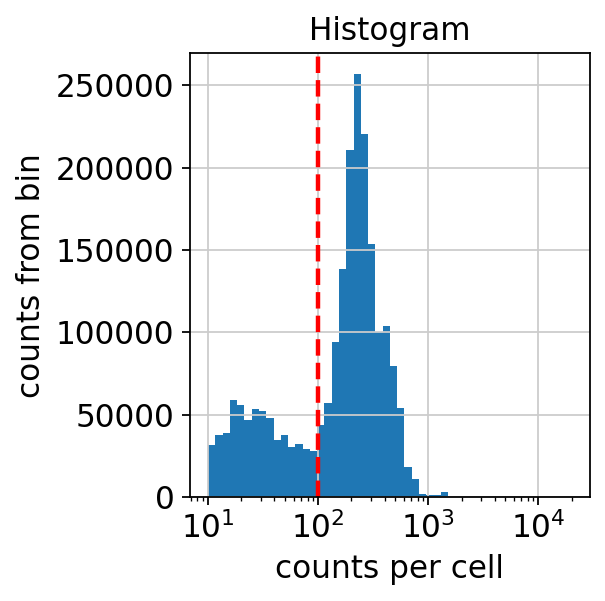

In [55]:
bins = np.logspace(np.log10(10),np.log10(20000),51)

# histograms:
plt.hist(adata.obs["total_counts"], bins = bins, weights = adata.obs["total_counts"])
plt.xscale('log')
plt.ylabel("counts from bin")
plt.xlabel("counts per cell")
plt.title("Histogram")

# tresholds (set manually):
plt.axvline(x=100, color='red', linestyle='dashed', linewidth=2)

plt.tight_layout()
plt.show()

So let's filter cells based on the above treshholds:

In [56]:
cmask = adata.obs['total_counts'].values>100
adata = adata[cmask]

print(adata.shape)

(6678, 2008)


Filtering low expression genes:

In [57]:
# Filtering low expression genes:
sc.pp.filter_genes(adata, min_cells=3)

In [58]:
print(adata.shape)

(6678, 2007)


Let's filter low quality cells. We will use automatic thresholding via MAD (median absolute deviations). The MAD is given by $ MAD = median(|X_i - median(X)|) $, with $X_i$ being the respective QC metric of an observation and describes a robust statistic of the variability of the metric. I will mark cells as outliers if they differ by 5 MADs which is a relatively permissive filtering strategy.

In [59]:
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

We will use thresholds on "log1p_total_counts", "log1p_n_genes_by_counts" and "pct_counts_mt", as abnormalities in these metrics might correspond to dying cells (e.g. if a membrane of a cell is damaged, cytoplasmic RNA migth leak out, while mitochondrial RNA remains for longer time, resulting in high percentage of mitochondrial genes and low total counts). We apply stricter thresholds for mitochondrial genes.

In [60]:
adata.obs["outlier"] = (
    is_outlier(adata, "log1p_total_counts", 5)
    | is_outlier(adata, "log1p_n_genes_by_counts", 5)
)

In [61]:
print(f"Total number of cells: {adata.n_obs}")
adata = adata[(~adata.obs.outlier)].copy()
print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

Total number of cells: 6678
Number of cells after filtering of low quality cells: 6659


## Doublets Detections

In some rare cases, we can have two cells in one droplet, leading to so called "doublets". To overcome this problem, we need to filter out those barcodes. We will use the method called Scrublet.

In [62]:
sc.external.pp.scrublet(adata)

In [63]:
cmask = adata.obs['predicted_doublet'].values == False
adata = adata[cmask]

In [64]:
print(adata.shape)

(6658, 2007)


## Visualisation

Plotting highest expression genes:

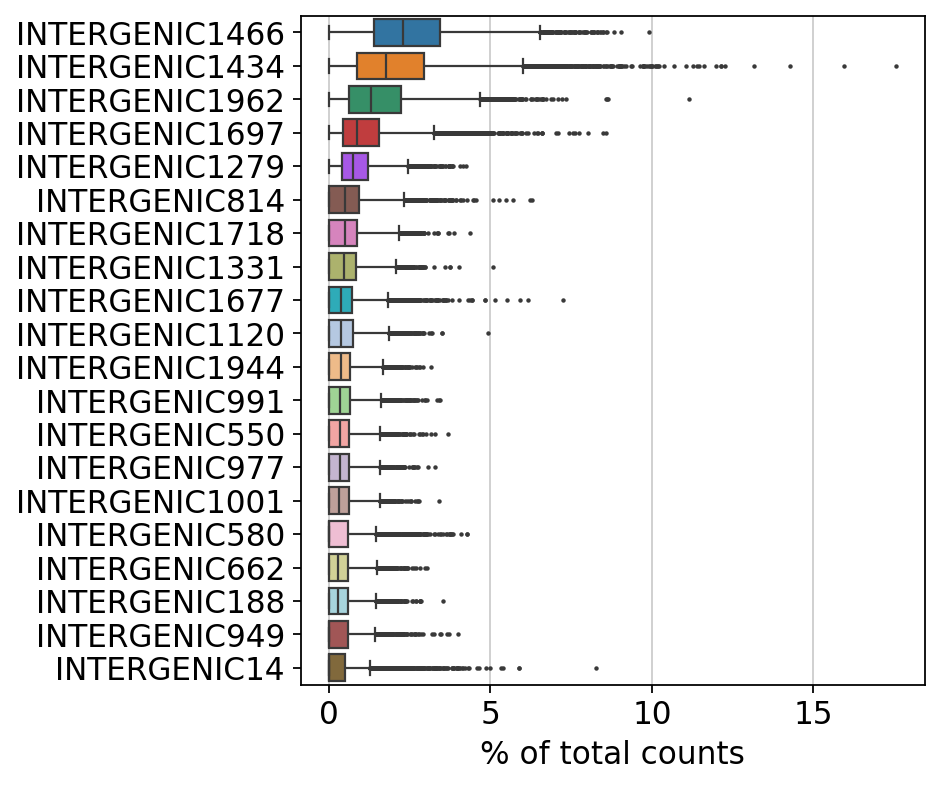

<Figure size 320x320 with 0 Axes>

In [65]:
%matplotlib inline

sc.pl.highest_expr_genes(adata, n_top=20, show=True)

plt.tight_layout()
plt.show()

... storing 'feature_types' as categorical


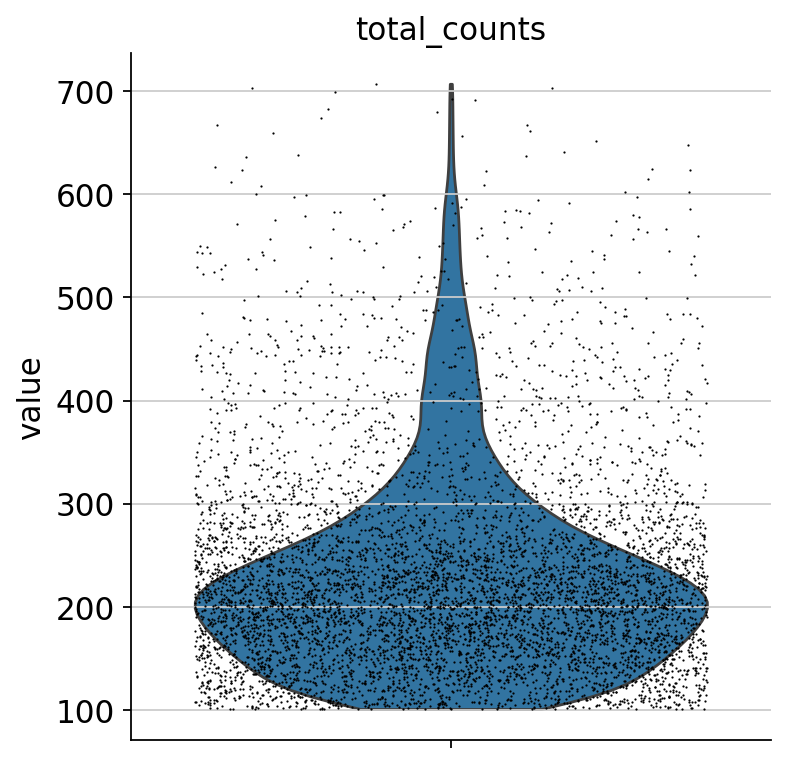

In [66]:
sc.pl.violin(adata, keys=['total_counts'], jitter=0.4, multi_panel=True)

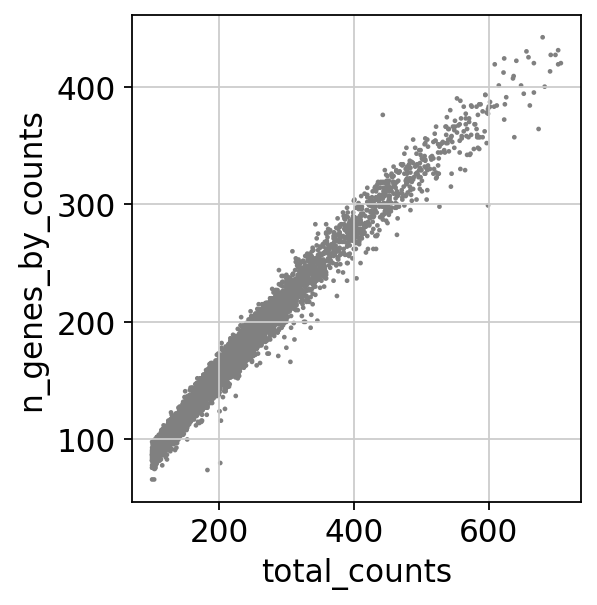

In [67]:
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', show=True)

# Normalization

Differences in count data between cells migth be the result due to sampling effects. Hence before proceeding with analysis, we need to normilize data. There are several normalization techniques (e.g. the shifted logarithm transformation, scran normalization and analytic approximation of Pearson residuals), each are well suited for different tasks. Here we will use shifted logarithm transformation, which works well for stabilizing variance for subsequent dimensionality reduction and identification of differentially expressed genes.

Before normalization:


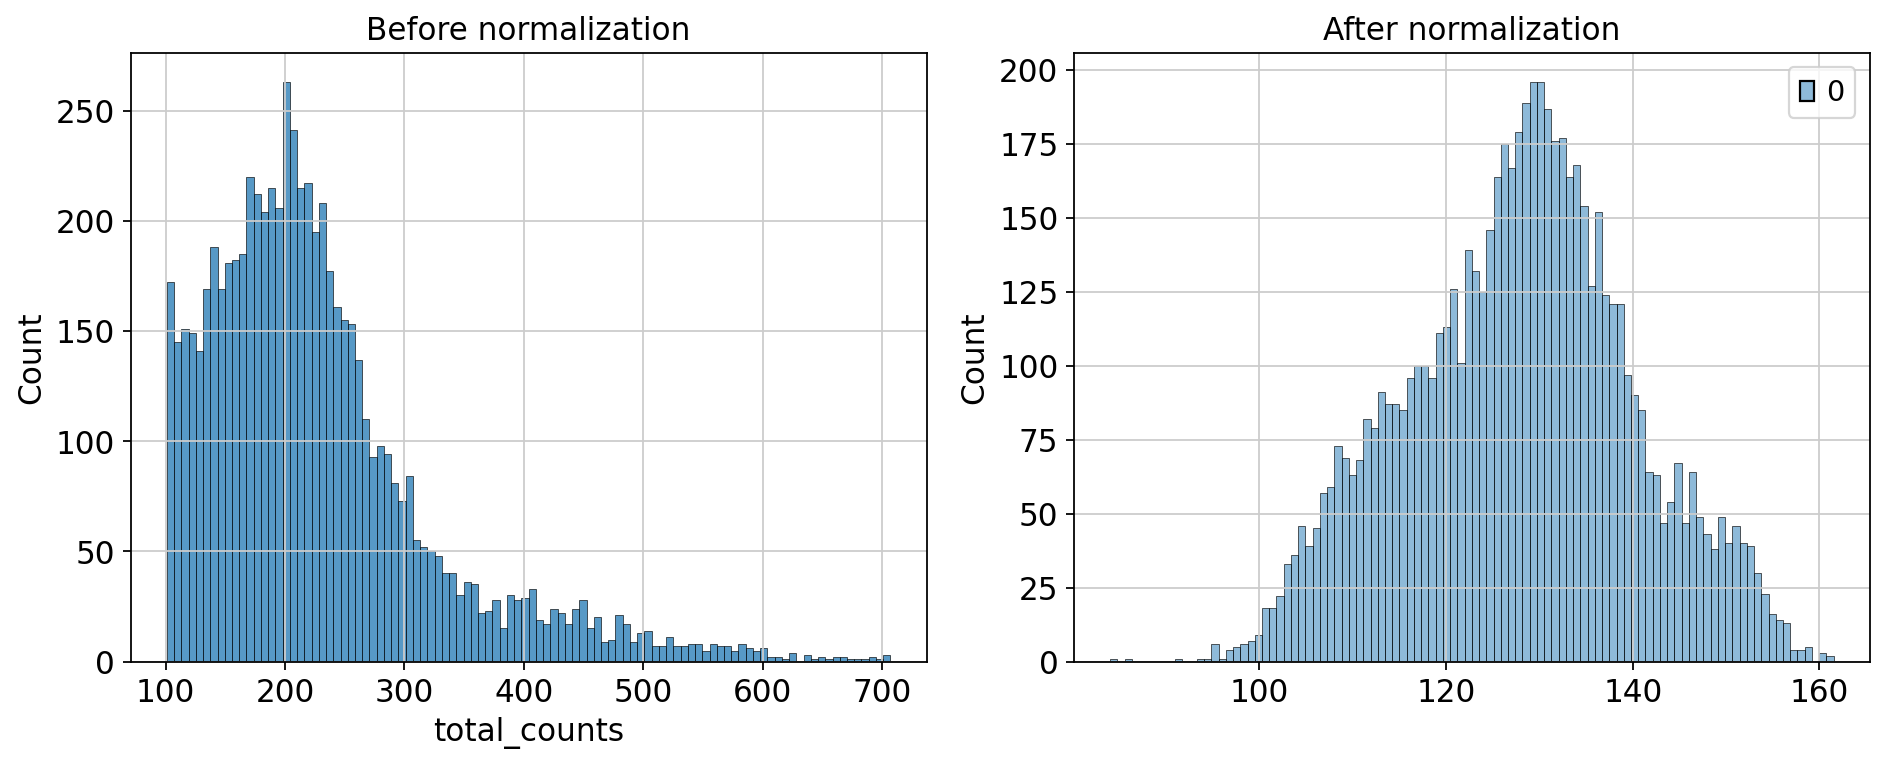

In [68]:
print("Before normalization:")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Before normalization")

sc.pp.normalize_total(adata, target_sum=None)
sc.pp.log1p(adata)

sns.histplot(adata.X.sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("After normalization")

plt.tight_layout()
plt.show()

# Feature Selection

In [69]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

In [70]:
adata = adata[:, adata.var.highly_variable]

In [71]:
print(adata.shape)

(6658, 440)


# Dimensionality reduction

## PCA

PCA is common strategy to construct the new set of variables with decreasing variance. In scRNA analysis, it is usually not used for clustering, instead, it is typically used to select the top 10-50 PCs which are used for downstream analysis tasks.

In [72]:
sc.tl.pca(adata, svd_solver='arpack')

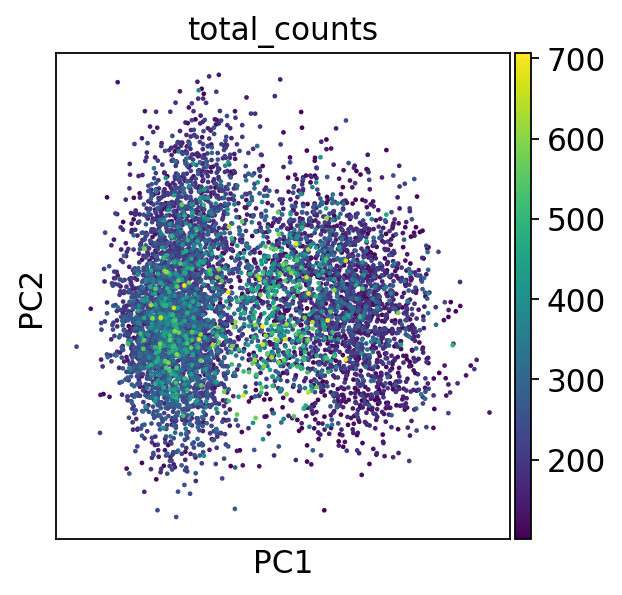

In [73]:
sc.pl.pca(adata, color='total_counts', show=True)

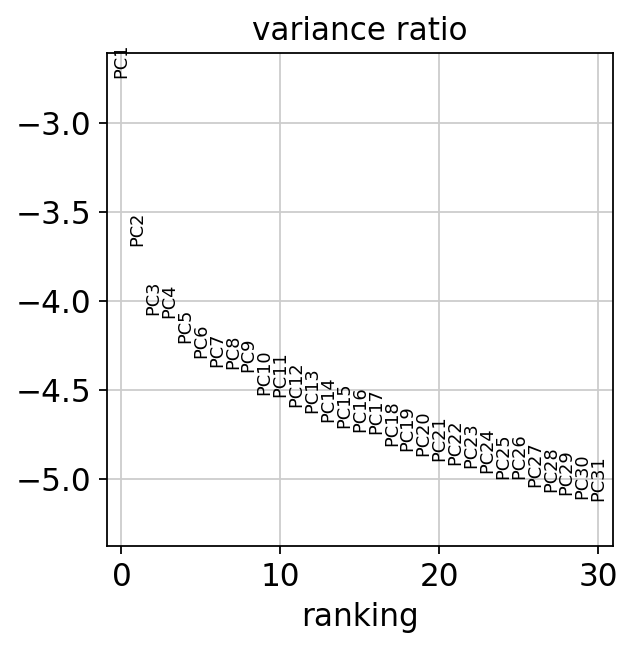

In [74]:
sc.pl.pca_variance_ratio(adata, log=True)

## t-SNE

t-SNE is a graph based, non-linear dimensionality reduction technique which projects the high dimensional data onto 2D or 3D components.

In [81]:
sc.tl.tsne(adata, n_pcs = 5)

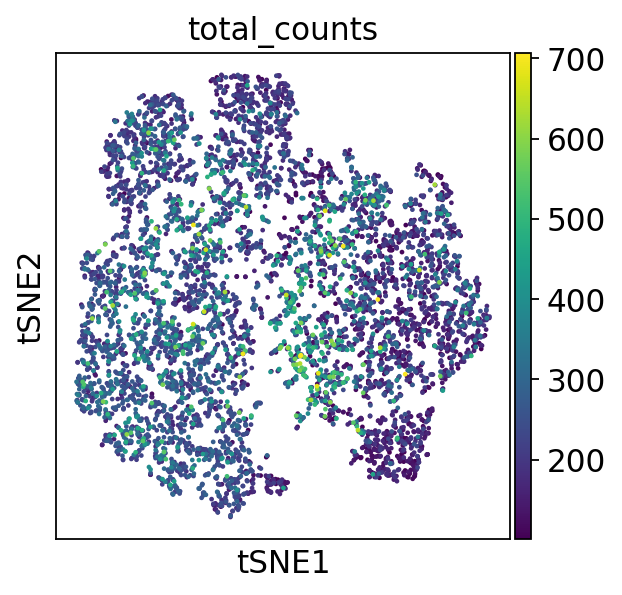

In [82]:
sc.pl.tsne(adata, color="total_counts", show=True)

## UMAP

UMAP is a graph based, non-linear dimensionality reduction technique and principally similar to t-SNE. To use UMAP, we firstly need to compute PCA and neighbours:

In [83]:
sc.pp.neighbors(adata, n_pcs = 5)
sc.tl.umap(adata)

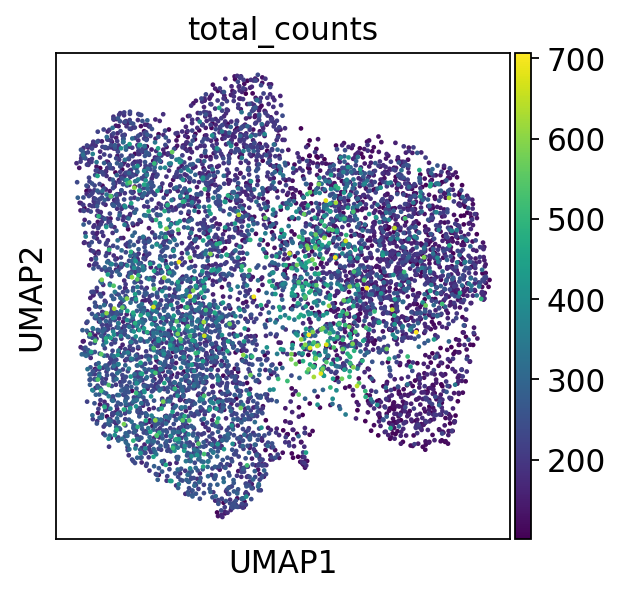

In [84]:
sc.pl.umap(adata, color="total_counts", show=True)

# INTERGENIC

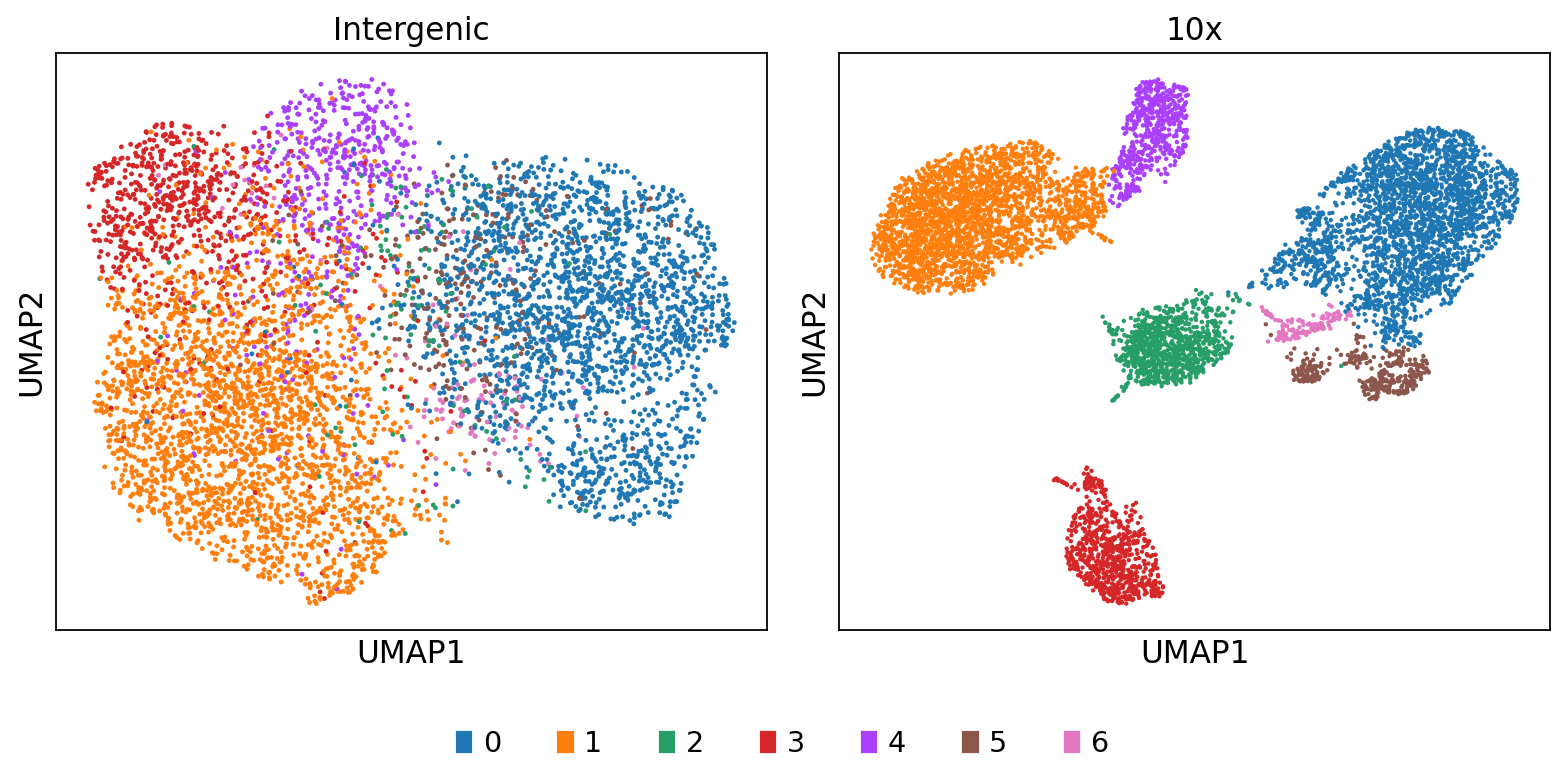

In [85]:
adata.obs['leiden01'] = adata_10x.obs['leiden01'].reindex(adata.obs_names)
adata = adata[~adata.obs['leiden01'].isna()].copy()

adata_10x.obs['leiden01'] = adata_10x.obs['leiden01'].cat.set_categories(adata.obs['leiden01'].cat.categories)
adata.uns['leiden01_colors'] = adata_10x.uns['leiden01_colors']

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sc.pl.umap(adata, color='leiden01', title='Intergenic', show=False, ax=axes[0], legend_loc=None)
sc.pl.umap(adata_10x, color='leiden01', title='10x', show=False, ax=axes[1], legend_loc=None)

# Create a custom legend
import matplotlib.patches as mpatches
colors = adata.uns['leiden01_colors']  # Assuming the colors are stored here
labels = adata.obs['leiden01'].cat.categories
legend_patches = [mpatches.Patch(color=colors[i], label=label) for i, label in enumerate(labels)]

# Add the legend below both subplots
fig.legend(handles=legend_patches, loc='lower center', ncol=len(labels), frameon=False)

plt.tight_layout(rect=[0, 0.1, 1, 1])  # Leave space for the legend
plt.savefig("../../images/umaps/intergenic_10x_indrops_2.png", dpi=300)
plt.show()

In [86]:
adata.write("../../data/downstream/adatas/PBMC_indrops_2_intergenic.h5ad")

# Checking

In [185]:
# Loading cell-gene matrices:
adata_10x = sc.read_10x_mtx('/home/juzis/Studijos/Thesis/data/PBMC_matrices/10x/')
adata_final = sc.read_10x_mtx('/home/juzis/Studijos/Thesis/data/PBMC_matrices/final/')

In [186]:
all_genes = np.union1d(adata_10x.var_names, adata_final.var_names)

In [187]:
print(len(adata_10x.var_names))
print(len(adata_final.var_names))
print(len(all_genes))

38593
39337
39462


In [188]:
adata_10x[1,:10].var

gene_ids    feature_types
DDX11L2          ENSG00000290825  Gene Expression
MIR1302-2HG      ENSG00000243485  Gene Expression
FAM138A          ENSG00000237613  Gene Expression
ENSG00000290826  ENSG00000290826  Gene Expression
OR4F5            ENSG00000186092  Gene Expression
ENSG00000238009  ENSG00000238009  Gene Expression
ENSG00000239945  ENSG00000239945  Gene Expression
ENSG00000239906  ENSG00000239906  Gene Expression
ENSG00000241860  ENSG00000241860  Gene Expression
ENSG00000241599  ENSG00000241599  Gene Expression

In [189]:
adata_10x[:, ['ENSG00000238009']]

View of AnnData object with n_obs × n_vars = 6794880 × 1
    var: 'gene_ids', 'feature_types'

In [190]:
# Step 1: Align gene sets by combining the genes in both datasets
# Add missing genes with zero expression in both datasets
all_genes = np.intersect1d(adata_10x.var_names, adata_final.var_names)

# Reindex both adatas to ensure they have the same genes
adata_10x = adata_10x[:, all_genes].copy()
adata_final = adata_final[:, all_genes].copy()

# Step 2: Replace NaN values (for genes not present in one dataset) with zeros
adata_10x.X = np.nan_to_num(adata_10x.X)  # Assuming 'raw' contains the data to compare
adata_final.X = np.nan_to_num(adata_final.X)

# Step 3: Calculate total counts per gene in both datasets
total_counts_10x = np.array(adata_10x.X.sum(axis=0)).flatten()
total_counts_final = np.array(adata_final.X.sum(axis=0)).flatten()

# Step 4: Calculate the difference in gene counts (final - 10x)
gene_comparison = pd.DataFrame({
    'gene': all_genes,
    'total_counts_adata_10x': total_counts_10x,
    'total_counts_adata_final': total_counts_final,
    'count_difference': total_counts_final - total_counts_10x  # Calculate difference
})

# Step 5: Sort by the count difference to find the most different genes
gene_comparison_sorted = gene_comparison.sort_values(by='count_difference', ascending=False)

# Display the comparison
# Print the first few rows (head) and last few rows (tail) of the specified columns
print(gene_comparison_sorted[['gene', 'total_counts_adata_10x', 'total_counts_adata_final', 'count_difference']].head())
print(gene_comparison_sorted[['gene', 'total_counts_adata_10x', 'total_counts_adata_final', 'count_difference']].tail())


           gene  total_counts_adata_10x  total_counts_adata_final  \
21044      HBA2                863856.0                 1373518.0   
34351   STEAP1B                 26401.0                  250797.0   
32087    RPL18A                110545.0                  148172.0   
21335   HNRNPA1                     0.0                   22328.0   
19083  FAM153CP                  1646.0                   23105.0   

       count_difference  
21044          509662.0  
34351          224396.0  
32087           37627.0  
21335           22328.0  
19083           21459.0  
           gene  total_counts_adata_10x  total_counts_adata_final  \
26232       LYN                 38581.0                   17137.0   
786     ANKRD12                 31055.0                    3149.0   
31332  RABGAP1L                 33454.0                    1609.0   
32121      RPL6                 95176.0                   49465.0   
1070   ARHGAP15                 61105.0                    9378.0   

       count_d